In [1]:
from utils import spark_session

session = spark_session("purchase-suppression-tmp")

24/11/03 07:39:57 INFO SecurityManager: Changing view acls to: olivyatan,b_perso,*
24/11/03 07:39:57 INFO SecurityManager: Changing modify acls to: olivyatan,b_perso
24/11/03 07:39:57 INFO SecurityManager: Changing view acls groups to: 
24/11/03 07:39:57 INFO SecurityManager: Changing modify acls groups to: 
24/11/03 07:39:57 INFO SecurityManager: SecurityManager: authentication disabled; ui acls disabled; users  with view permissions: Set(olivyatan, b_perso, *); groups with view permissions: Set(); users  with modify permissions: Set(olivyatan, b_perso); groups with modify permissions: Set()
24/11/03 07:39:57 INFO deprecation: mapred.reduce.tasks is deprecated. Instead, use mapreduce.job.reduces
24/11/03 07:39:58 INFO SparkContext: Running Spark version 3.1.1.0.1.0
24/11/03 07:39:58 INFO ResourceUtils: ==============================================================
24/11/03 07:39:58 INFO ResourceUtils: No custom resources configured for spark.driver.
24/11/03 07:39:58 INFO ResourceUtil

# Train/eval model

## Load train test data

In [2]:
import pandas as pd

In [3]:
#train_df = session.table("bx_ps_features_train_1") #views and purchases
#eval_df = session.table("bx_ps_features_test_1")

In [4]:
train_df = session.table( "bx_ps_features_train_user_behave_1")#views and purchases and searches 
eval_df = session.table( "bx_ps_features_test_user_behave_1")

In [5]:
from features import filter_inactive_buyers

config = dict()
config['sampling'] = {
    'ref_dt': '2024-05-01'
}

df_vi = session.table("bx_ps_user_vi_hist_1")
train_df = filter_inactive_buyers(session, config, train_df, df_vi)

In [6]:
from features import vi_label

train_df = vi_label(session, config, train_df, df_vi)
eval_df = vi_label(session, config, eval_df, df_vi)

In [7]:
train_df = train_df.toPandas()
eval_df = eval_df.toPandas()

/apache/spark/python/pyspark/sql/pandas/conversion.py:186: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  df[column_name] = series


In [8]:
train_df.shape, eval_df.shape #  of srchs prchs vis  

((54643, 915), (20035, 915))

In [9]:
#train_df.shape, eval_df.shape # prev of prchs vis 

In [9]:
!pwd

/data/shpx/notebooks/olivyatan/purchase_suppression/user_priors


In [10]:
train_df = train_df.fillna(-1)#changed from 0 
eval_df = eval_df.fillna(-1)
len(train_df)

54643

In [11]:
train_df.columns

Index(['BUYER_ID', 'LEAF_CATEG_ID', 'f_time_since_last_purchase_from_LEAF_cat',
       'f_time_since_last_purchase_from_LVL2_cat',
       'f_time_since_last_purchase_from_META_cat',
       'f_time_since_last_view_from_LEAF_cat',
       'f_time_since_last_view_from_LVL2_cat',
       'f_time_since_last_view_from_META_cat',
       'f_num_purchases_from_LEAF_cat_in_last_1_days',
       'f_num_purchases_from_LEAF_cat_in_last_2_days',
       ...
       'f_user_vs_mean_view_from_META_cat_in_last_14_days',
       'f_user_vs_mean_view_from_META_cat_in_last_30_days',
       'f_user_vs_mean_view_from_META_cat_in_last_60_days',
       'f_user_vs_mean_view_from_META_cat_in_last_90_days',
       'f_user_vs_mean_view_from_META_cat_in_last_180_days',
       'f_user_vs_mean_view_from_META_cat_in_last_360_days', 'EVENT_TIMESTAMP',
       'label', 'num_repurchases', 'vi_label'],
      dtype='object', length=915)

In [12]:
# we don't supress buyers with no activity in a given leaf
train_df = train_df[train_df["f_num_purchases_from_LEAF_cat_in_last_360_days"] > 0]
eval_df = eval_df[eval_df["f_num_purchases_from_LEAF_cat_in_last_360_days"] > 0]
len(train_df)

53624

In [14]:
#train_df.to_parquet('/data/shpx/data/olivyatan/traindf_vi_51024.parquet') 
#eval_df.to_parquet('/data/shpx/data/olivyatan/evaldf_vi_51024.parquet')

### save train eval df parquet

In [13]:
#train_df.to_parquet('/data/shpx/data/olivyatan/traindf_vi_user_behave_291024.parquet') 
#eval_df.to_parquet('/data/shpx/data/olivyatan/evaldf_vi_user_behave_291024.parquet')

train_df.to_parquet('/data/shpx/data/olivyatan/traindf_user_behave_311024_top20.parquet') 
eval_df.to_parquet('/data/shpx/data/olivyatan/evaldf_user_behave_311024_top20.parquet')

In [14]:
#import pandas as pd
#train_df=pd.read_parquet('/data/shpx/data/olivyatan/traindf_vi_51024.parquet') 
#eval_df=pd.read_parquet(('/data/shpx/data/olivyatan/evaldf_vi_51024.parquet')) *\

In [15]:
train_df.shape, eval_df.shape

((53624, 915), (19645, 915))

In [16]:
label_counts = train_df['vi_label'].value_counts()
print("VI Label counts:")
print(label_counts)

VI Label counts:
0    39906
1    13718
Name: vi_label, dtype: int64


#### Features list and label:

In [17]:
#origin 832 features 
df_origin=session.table( "bx_ps_features_1")

#919 features of user behaviour 
df_behave=session.table("bx_ps_features_user_behave_f_1")

In [20]:
# Get feature columns from each DataFrame
behave_f_columns = [col for col in df_behave.columns if col.startswith('f_')]
origin_f_columns = [col for col in df_origin.columns if col.startswith('f_')]

# Find columns in df_behave but not in df_origin
new_features = list(set(behave_f_columns) - set(origin_f_columns))
new_features

['f_min_time_since_first_view_after_purchase_in_LVL2_cat',
 'f_user_vs_mean_view_from_LEAF_cat_in_last_7_days',
 'f_user_vs_mean_view_from_LEAF_cat_in_last_14_days',
 'f_num_views_since_last_purchase_in_META_cat',
 'f_user_vs_mean_purchase_from_LVL2_cat_in_last_14_days',
 'f_user_vs_mean_purchase_from_LVL2_cat_in_last_2_days',
 'f_mean_time_since_first_view_after_purchase_in_LEAF_cat',
 'f_num_views_since_last_purchase_in_LVL2_cat',
 'f_mean_time_since_first_view_after_purchase_in_LVL2_cat',
 'f_entropy_for_META_cat_purchases',
 'f_user_vs_mean_view_from_LEAF_cat_in_last_180_days',
 'f_user_vs_mean_purchase_from_META_cat_in_last_14_days',
 'f_time_from_last_view_to_last_purchase_in_LEAF_cat',
 'f_user_vs_mean_view_from_LVL2_cat_in_last_2_days',
 'f_min_time_since_first_view_after_purchase_in_META_cat',
 'f_user_vs_mean_purchase_from_LVL2_cat_in_last_30_days',
 'f_max_views_between_purchases_per_days_in_LEAF_cat',
 'f_user_vs_mean_purchase_from_LVL2_cat_in_last_360_days',
 'f_user_vs_me

In [21]:
# Provided list of features
mvp_features = ['f_max_META_cat_view_propensity_jaccard_sim_in_last_360_days',
 'f_num_views_from_LEAF_cat_in_last_30_days',
 'f_max_LVL2_cat_view_propensity_jaccard_sim_in_last_360_days',
 'f_num_purchases_from_LEAF_cat_in_last_360_days',
 'f_max_LEAF_cat_view_propensity_jaccard_sim_in_last_360_days',
 'f_max_LEAF_cat_view_propensity_cosine_sim_in_last_30_days',
 'f_num_views_from_LEAF_cat_in_last_14_days',
 'f_max_LEAF_cat_view_propensity_cosine_sim_in_last_14_days',
 'f_max_LEAF_cat_view_propensity_jaccard_sim_in_last_30_days',
 'f_num_views_from_LEAF_cat_in_last_2_days',
 'f_num_purchases_from_LVL2_cat_in_last_360_days',
 'f_num_views_from_LEAF_cat_in_last_360_days',
 'f_max_LEAF_cat_view_propensity_cosine_sim_in_last_90_days',
 'f_max_LEAF_cat_view_propensity_cosine_sim_in_last_60_days',
 'f_num_views_from_LEAF_cat_in_last_180_days',
 'f_num_purchases_from_LEAF_cat_in_last_180_days',
 'f_num_views_from_LEAF_cat_in_last_7_days',
 'f_time_since_last_view_from_LEAF_cat',
 'f_num_purchases_from_LEAF_cat_in_last_30_days',
 'f_time_since_last_view_from_LVL2_cat'] 
# Combine `new_features` and `provided_features` into a single list without duplicates
combined_features = list(set(new_features + mvp_features))
combined_features

['f_min_time_since_first_view_after_purchase_in_LVL2_cat',
 'f_user_vs_mean_view_from_LEAF_cat_in_last_7_days',
 'f_user_vs_mean_view_from_LEAF_cat_in_last_14_days',
 'f_num_purchases_from_LEAF_cat_in_last_180_days',
 'f_num_views_since_last_purchase_in_META_cat',
 'f_user_vs_mean_purchase_from_LVL2_cat_in_last_14_days',
 'f_user_vs_mean_purchase_from_LVL2_cat_in_last_2_days',
 'f_mean_time_since_first_view_after_purchase_in_LEAF_cat',
 'f_num_views_since_last_purchase_in_LVL2_cat',
 'f_mean_time_since_first_view_after_purchase_in_LVL2_cat',
 'f_entropy_for_META_cat_purchases',
 'f_user_vs_mean_view_from_LEAF_cat_in_last_180_days',
 'f_user_vs_mean_purchase_from_META_cat_in_last_14_days',
 'f_time_from_last_view_to_last_purchase_in_LEAF_cat',
 'f_min_time_since_first_view_after_purchase_in_META_cat',
 'f_user_vs_mean_view_from_LVL2_cat_in_last_2_days',
 'f_user_vs_mean_purchase_from_LVL2_cat_in_last_30_days',
 'f_max_views_between_purchases_per_days_in_LEAF_cat',
 'f_user_vs_mean_purch

In [22]:
len(origin_f_columns)

822

In [23]:
len(mvp_features), len(new_features), len(combined_features)

(20, 87, 107)

##### all features with new features:

In [24]:
combined_features_all_new = list(set(new_features + origin_f_columns))
len(combined_features_all_new) #822+87

909

In [25]:
#feature_list = [f for f in train_df.columns if f.startswith("f_")]
feature_list = combined_features 
label = "vi_label"#"label"

#### features dist:

In [27]:
# Initialize an empty dictionary to store results
results = {}

# Loop through each feature column in combined_features and calculate metrics
for col in mvp_features:
    total_count = len(train_df[col])
    pos_count = (train_df[col] > 0).sum()  # Count of values > 0
    zero_count = (train_df[col] == 0).sum()  # Count of values == 0
    neg_one_count = (train_df[col] == -1).sum()  # Count of values == -1
    below_zero_not_neg_one_count = ((train_df[col] < 0) & (train_df[col] != -1)).sum()  # Count of values < 0 and not -1

    # Calculate percentages
    pos_percent = (pos_count / total_count) * 100
    zero_percent = (zero_count / total_count) * 100
    neg_one_percent = (neg_one_count / total_count) * 100
    below_zero_not_neg_one_percent = (below_zero_not_neg_one_count / total_count) * 100

    # Calculate mean and std for values above 0
    pos_values = train_df[col][train_df[col] > 0]
    pos_mean = pos_values.mean() if not pos_values.empty else None
    pos_std = pos_values.std() if not pos_values.empty else None

    # Store results for this feature
    results[col] = {
        '> 0 %': pos_percent,
        '== 0 %': zero_percent,
        '== -1 %': neg_one_percent,
        '< 0 and != -1 %': below_zero_not_neg_one_percent,
        'Mean (> 0)': pos_mean,
        'Std (> 0)': pos_std
    }

# Convert results to a DataFrame for better readability
results_df = pd.DataFrame(results).T



In [28]:
results_df.head(30)

,> 0 %,== 0 %,== -1 %,< 0 and != -1 %,Mean (> 0),Std (> 0)
f_max_META_cat_view_propensity_jaccard_sim_in_last_360_days,89.793749,10.206251,0.000000,0.0,0.978635,0.100400
f_num_views_from_LEAF_cat_in_last_30_days,21.395271,78.604729,0.000000,0.0,16.406171,36.934137
f_max_LVL2_cat_view_propensity_jaccard_sim_in_last_360_days,89.784425,10.215575,0.000000,0.0,0.956555,0.135565
f_num_purchases_from_LEAF_cat_in_last_360_days,100.000000,0.000000,0.000000,0.0,2.385201,10.526318
f_max_LEAF_cat_view_propensity_jaccard_sim_in_last_360_days,89.793749,10.206251,0.000000,0.0,0.973910,0.070411
f_max_LEAF_cat_view_propensity_cosine_sim_in_last_30_days,81.467253,18.532747,0.000000,0.0,0.905663,0.092718
f_num_views_from_LEAF_cat_in_last_14_days,13.631956,86.368044,0.000000,0.0,12.459644,26.167440
f_max_LEAF_cat_view_propensity_cosine_sim_in_last_14_days,73.334701,26.665299,0.000000,0.0,0.884515,0.098701
f_max_LEAF_cat_view_propensity_jaccard_sim_in_last_30_days,81.467253,18.532747,0.000000,0.0,0.849626,0.137717
f_num_views_from_LEAF_cat_in_last_2_days,3.813591,96.186409,0.000000,0.0,6.507090,12.716331


### Downsample majority class

In [29]:
#perform downsampling
from sklearn.utils import resample
import pandas as pd

_train_df = train_df#train_no_entu_df
# Assuming df is your DataFrame and 'class' is your target variable
majority_class = _train_df[_train_df[label] == 0]
minority_class = _train_df[_train_df[label] == 1]

# Downsample majority class
majority_downsampled = resample(majority_class, 
                                replace=False,    # sample without replacement
                                n_samples=len(minority_class),     # to match minority class
                                random_state=123) # reproducible results

# Combine minority class with downsampled majority class
df_balanced = pd.concat([majority_downsampled, minority_class])

# Display new class counts
print(df_balanced[label].value_counts())

0    13718
1    13718
Name: vi_label, dtype: int64


In [30]:
_train_df = df_balanced
_eval_df = eval_df

### Train xgb 

In [12]:
#!pip install xgboost --user --proxy=httpproxy-tcop.vip.ebay.com:80


[notice] A new release of pip is available: 23.0 -> 24.0
[notice] To update, run: pip install --upgrade pip


#### Basline: Mvp features

In [109]:
len(mvp_features)

20

In [110]:
feature_list = mvp_features 

In [111]:
feature_list

['f_max_META_cat_view_propensity_jaccard_sim_in_last_360_days',
 'f_num_views_from_LEAF_cat_in_last_30_days',
 'f_max_LVL2_cat_view_propensity_jaccard_sim_in_last_360_days',
 'f_num_purchases_from_LEAF_cat_in_last_360_days',
 'f_max_LEAF_cat_view_propensity_jaccard_sim_in_last_360_days',
 'f_max_LEAF_cat_view_propensity_cosine_sim_in_last_30_days',
 'f_num_views_from_LEAF_cat_in_last_14_days',
 'f_max_LEAF_cat_view_propensity_cosine_sim_in_last_14_days',
 'f_max_LEAF_cat_view_propensity_jaccard_sim_in_last_30_days',
 'f_num_views_from_LEAF_cat_in_last_2_days',
 'f_num_purchases_from_LVL2_cat_in_last_360_days',
 'f_num_views_from_LEAF_cat_in_last_360_days',
 'f_max_LEAF_cat_view_propensity_cosine_sim_in_last_90_days',
 'f_max_LEAF_cat_view_propensity_cosine_sim_in_last_60_days',
 'f_num_views_from_LEAF_cat_in_last_180_days',
 'f_num_purchases_from_LEAF_cat_in_last_180_days',
 'f_num_views_from_LEAF_cat_in_last_7_days',
 'f_time_since_last_view_from_LEAF_cat',
 'f_num_purchases_from_LEAF

In [112]:
import xgboost as xgb
import numpy as np

def train_eval_model(hyperp, feature_list, label, train_df, eval_df, preds_col='preds', verbose=True):
    model = xgb.XGBClassifier(
        **hyperp
    )
    
    model = model.fit(train_df[feature_list], train_df[label], verbose=verbose)
    eval_df[preds_col] = model.predict(eval_df[feature_list])
    return model, eval_df

hyperp = {
    'tree_method': 'hist',
    'booster': 'gbtree',
    'objective': 'binary:logistic',
    'random_state': 42, 
    'learning_rate': 0.01,
    'colsample_bytree': 0.5, 
    'eta': 0.05, 
    'max_depth': 20,#12,
    'n_estimators': 500,#500
    'subsample': 0.75,
    'lambda': 100
}



In [113]:
model, eval_df = train_eval_model(hyperp, feature_list, label, _train_df, _eval_df, preds_col='preds')

#### save model params

In [36]:
#model.save_model('/data/shpx/data/olivyatan/purchase_suppression/ps_vi_xgb_51024.model')  
#model.save_model('/data/shpx/data/olivyatan/purchase_suppression/ps_vi_xgb_srchs_81024.model')  
#model.save_model('/data/shpx/data/olivyatan/purchase_suppression/ps_vi_xgb_user_behave_291024.model') 
#model.save_model('/data/shpx/data/olivyatan/purchase_suppression/ps_vi_xgb_user_behave_301024_mvp.model') 
model.save_model('/data/shpx/data/olivyatan/purchase_suppression/ps_vi_xgb_user_behave_311024_mvp.model') 

In [37]:
import pickle

#file_name = '/data/shpx/data/olivyatan/purchase_suppression/ps_vi_xgb_51024.pkl'
#file_name = '/data/shpx/data/olivyatan/purchase_suppression/ps_vi_xgb_srchs_81024.pkl'
#file_name = '/data/shpx/data/olivyatan/purchase_suppression/ps_vi_xgb_user_behave_291024.pkl'
#file_name = '/data/shpx/data/olivyatan/purchase_suppression/ps_vi_xgb_user_behave_301024_mvp.pkl' 
file_name = '/data/shpx/data/olivyatan/purchase_suppression/ps_vi_xgb_user_behave_311024_mvp.pkl' 

# save
pickle.dump(model, open(file_name, "wb"))

In [49]:
#import pickle
#file_name = '/data/shpx/data/olivyatan/purchase_suppression/ps_vi_xgb_51024.pkl'
file_name = '/data/shpx/data/olivyatan/purchase_suppression/ps_vi_xgb_user_behave_291024.pkl'
model_xgb = pickle.load(open(file_name, "rb"))

In [28]:
# Step 1: Get the previous model's feature names
previous_model_features = model_xgb.get_booster().feature_names

# Step 2: Filter eval_df to only include the features present in the previous model
common_features = [col for col in eval_df.columns if col in previous_model_features]

# Step 3: Predict using the previous model on the new data with the common features
eval_df['prev_model_preds'] = model_xgb.predict(eval_df[common_features])

# Now eval_df will have a new column 'prev_model_preds' containing predictions


### Model results metrics

### Baseline mvp- top 20 features

In [114]:
from sklearn.metrics import roc_auc_score, precision_score, recall_score, classification_report

_eval_df = eval_df   #[eval_df["f_num_views_from_LEAF_cat_in_last_360_days"] >= 50]
y_test, y_pred = _eval_df[label].values, _eval_df['preds'].values
acc = sum(y_test == y_pred) / len(y_test)
roc_auc = roc_auc_score(y_test, y_pred)
precision_micro = precision_score(y_test, y_pred, average='micro')
recall_micro = recall_score(y_test, y_pred, average='micro')
precision_macro = precision_score(y_test, y_pred, average='macro')
recall_macro = recall_score(y_test, y_pred, average='macro')

label_counts = eval_df[label].value_counts()
print("Label counts:")
print(label_counts)

print("Metrics:")
print(f'Accuracy: {acc}')
print(f'ROC AUC: {roc_auc}')
print(f'Precision (micro): {precision_micro}')
print(f'Recall (micro): {recall_micro}')
print(f'Precision (macro): {precision_macro}')
print(f'Recall (macro): {recall_macro}')
report = classification_report(y_test, y_pred, target_names=['0', '1'])
print(report)

Label counts:
0    15707
1     3938
Name: vi_label, dtype: int64
Metrics:
Accuracy: 0.780198523797404
ROC AUC: 0.7553281455609636
Precision (micro): 0.780198523797404
Recall (micro): 0.780198523797404
Precision (macro): 0.6928687102588857
Recall (macro): 0.7553281455609635
              precision    recall  f1-score   support

           0       0.92      0.80      0.85     15707
           1       0.47      0.71      0.57      3938

    accuracy                           0.78     19645
   macro avg       0.69      0.76      0.71     19645
weighted avg       0.83      0.78      0.80     19645



### New features model:

In [39]:
feature_list = combined_features 

In [40]:
len(feature_list)

107

In [60]:
import xgboost as xgb
import numpy as np
def train_eval_model(hyperp, feature_list, label, train_df, eval_df, verbose=True):
    model = xgb.XGBClassifier(
        **hyperp
    )
    
    model = model.fit(train_df[feature_list], train_df[label], verbose=verbose)
    eval_df['preds_new'] = model.predict(eval_df[feature_list])
    return model, eval_df

hyperp = {
    'tree_method': 'hist',
    'booster': 'gbtree',
    'objective': 'binary:logistic',
    'random_state': 42, 
    'learning_rate': 0.01,
    'colsample_bytree': 0.5, 
    'eta': 0.05, 
    'max_depth': 20,#12,
    'n_estimators': 500,#500
    'subsample': 0.75,
    'lambda': 100
}
model_new, eval_df = train_eval_model(hyperp, feature_list, label, _train_df, _eval_df) 

model, eval_df = train_eval_model(hyperp, feature_list, label, _train_df, _eval_df, preds_col='preds_new')

In [41]:
model_new, eval_df = train_eval_model(hyperp, feature_list, label, _train_df, _eval_df, preds_col='preds_new')

#### results new model

In [42]:
from sklearn.metrics import roc_auc_score, precision_score, recall_score, classification_report

_eval_df = eval_df   #[eval_df["f_num_views_from_LEAF_cat_in_last_360_days"] >= 50]
y_test, y_pred = _eval_df[label].values, _eval_df['preds_new'].values
acc = sum(y_test == y_pred) / len(y_test)
roc_auc = roc_auc_score(y_test, y_pred)
precision_micro = precision_score(y_test, y_pred, average='micro')
recall_micro = recall_score(y_test, y_pred, average='micro')
precision_macro = precision_score(y_test, y_pred, average='macro')
recall_macro = recall_score(y_test, y_pred, average='macro')

label_counts = eval_df[label].value_counts()
print("Label counts:")
print(label_counts)

print("Metrics:")
print(f'Accuracy: {acc}')
print(f'ROC AUC: {roc_auc}')
print(f'Precision (micro): {precision_micro}')
print(f'Recall (micro): {recall_micro}')
print(f'Precision (macro): {precision_macro}')
print(f'Recall (macro): {recall_macro}')
report = classification_report(y_test, y_pred, target_names=['0', '1'])
print(report)

Label counts:
0    15707
1     3938
Name: vi_label, dtype: int64
Metrics:
Accuracy: 0.7680325782641894
ROC AUC: 0.7574238491874582
Precision (micro): 0.7680325782641894
Recall (micro): 0.7680325782641894
Precision (macro): 0.6871633812915814
Recall (macro): 0.7574238491874581
              precision    recall  f1-score   support

           0       0.92      0.78      0.84     15707
           1       0.45      0.74      0.56      3938

    accuracy                           0.77     19645
   macro avg       0.69      0.76      0.70     19645
weighted avg       0.83      0.77      0.79     19645



In [43]:
#model.save_model('/data/shpx/data/olivyatan/purchase_suppression/ps_vi_xgb_user_behave_301024_new_features.model')
model_new.save_model('/data/shpx/data/olivyatan/purchase_suppression/ps_vi_xgb_user_behave_311024_new_features.model')

In [44]:
#file_name = '/data/shpx/data/olivyatan/purchase_suppression/ps_vi_xgb_user_behave_301024_new_features.pkl' 
file_name = '/data/shpx/data/olivyatan/purchase_suppression/ps_vi_xgb_user_behave_311024_new_features.pkl' 

# save
pickle.dump(model_new, open(file_name, "wb"))

#### compare: 

In [45]:
from sklearn.metrics import roc_auc_score, precision_score, recall_score, classification_report

def get_metrics(eval_df, label, preds):
    y_test = eval_df[label].values
    y_pred = preds
    
    # Calculate metrics
    acc = sum(y_test == y_pred) / len(y_test)
    roc_auc = roc_auc_score(y_test, y_pred)
    precision_micro = precision_score(y_test, y_pred, average='micro')
    recall_micro = recall_score(y_test, y_pred, average='micro')
    precision_macro = precision_score(y_test, y_pred, average='macro')
    recall_macro = recall_score(y_test, y_pred, average='macro')

    # Print metrics
    print("Metrics:")
    print(f'Accuracy: {round(acc, 3)}')
    print(f'ROC AUC: {round(roc_auc, 3)}')
    print(f'Precision (micro): {round(precision_micro, 3)}')
    print(f'Recall (micro): {round(recall_micro, 3)}')
    print(f'Precision (macro): {round(precision_macro, 3)}')
    print(f'Recall (macro): {round(recall_macro, 3)}')

    # Generate classification report
    report = classification_report(y_test, y_pred, target_names=['0', '1'])
    print("Classification Report:")
    print(report)
    
    # Return metrics as a dictionary
    metrics = {
        'accuracy': acc,
        'roc_auc': roc_auc,
        'precision_micro': precision_micro,
        'recall_micro': recall_micro,
        'precision_macro': precision_macro,
        'recall_macro': recall_macro
    }
    
    return metrics


In [46]:

# Example usage with baseline and new model predictions
baseline_metrics = get_metrics(_eval_df, label, _eval_df['preds'].values) 
baseline_metrics

Metrics:
Accuracy: 0.78
ROC AUC: 0.755
Precision (micro): 0.78
Recall (micro): 0.78
Precision (macro): 0.693
Recall (macro): 0.755
Classification Report:
              precision    recall  f1-score   support

           0       0.92      0.80      0.85     15707
           1       0.47      0.71      0.57      3938

    accuracy                           0.78     19645
   macro avg       0.69      0.76      0.71     19645
weighted avg       0.83      0.78      0.80     19645



{'accuracy': 0.780198523797404,
 'roc_auc': 0.7553281455609636,
 'precision_micro': 0.780198523797404,
 'recall_micro': 0.780198523797404,
 'precision_macro': 0.6928687102588857,
 'recall_macro': 0.7553281455609635}

In [47]:
new_metrics = get_metrics(_eval_df, label, _eval_df['preds_new'].values )
new_metrics

Metrics:
Accuracy: 0.768
ROC AUC: 0.757
Precision (micro): 0.768
Recall (micro): 0.768
Precision (macro): 0.687
Recall (macro): 0.757
Classification Report:
              precision    recall  f1-score   support

           0       0.92      0.78      0.84     15707
           1       0.45      0.74      0.56      3938

    accuracy                           0.77     19645
   macro avg       0.69      0.76      0.70     19645
weighted avg       0.83      0.77      0.79     19645



{'accuracy': 0.7680325782641894,
 'roc_auc': 0.7574238491874582,
 'precision_micro': 0.7680325782641894,
 'recall_micro': 0.7680325782641894,
 'precision_macro': 0.6871633812915814,
 'recall_macro': 0.7574238491874581}

In [48]:
# Function to compare metrics remains unchanged
def compare_metrics(baseline_metrics, new_metrics):
    diff_results = {}
    
    for metric in baseline_metrics:
        baseline_val = baseline_metrics[metric]
        new_val = new_metrics[metric]
        abs_diff = new_val - baseline_val
        perc_change = (abs_diff / baseline_val) * 100 if baseline_val != 0 else float('inf')
        
        diff_results[metric] = {
            'Baseline': round(baseline_val, 3),
            'New': round(new_val, 3),
            'Absolute Difference': round(abs_diff, 3),
            'Percentage Change (%)': round(perc_change, 3)
        }

    # Convert to DataFrame
    comparison_df = pd.DataFrame.from_dict(diff_results, orient='index')
    return comparison_df 




In [49]:
# Comparison results
comparison_results = compare_metrics(baseline_metrics, new_metrics)

# Printing comparison as DataFrame
print("Comparison of Metrics:")
print(comparison_results)


Comparison of Metrics:
                 Baseline    New  Absolute Difference  Percentage Change (%)
accuracy            0.780  0.768               -0.012                 -1.559
roc_auc             0.755  0.757                0.002                  0.277
precision_micro     0.780  0.768               -0.012                 -1.559
recall_micro        0.780  0.768               -0.012                 -1.559
precision_macro     0.693  0.687               -0.006                 -0.823
recall_macro        0.755  0.757                0.002                  0.277


### Feature importance

In [115]:
# feature importance
import numpy as np
print(f"Feature importance of ranker:")
importances = model.feature_importances_
indices = np.argsort(importances)[::-1]
feature_order = []
for f in range(_train_df.shape[1]):
    if f < len(indices):
        print(
            "%2d) %-*s %f" % (f + 1, 30, feature_list[indices[f]], importances[indices[f]])
        )
        feature_order.append(feature_list[indices[f]])

Feature importance of ranker:
 1) f_max_META_cat_view_propensity_jaccard_sim_in_last_360_days 0.145067
 2) f_num_views_from_LEAF_cat_in_last_30_days 0.142699
 3) f_num_purchases_from_LEAF_cat_in_last_360_days 0.133519
 4) f_max_LEAF_cat_view_propensity_jaccard_sim_in_last_360_days 0.076109
 5) f_max_LEAF_cat_view_propensity_cosine_sim_in_last_30_days 0.065089
 6) f_max_LVL2_cat_view_propensity_jaccard_sim_in_last_360_days 0.051422
 7) f_num_views_from_LEAF_cat_in_last_7_days 0.039299
 8) f_num_purchases_from_LVL2_cat_in_last_360_days 0.038477
 9) f_max_LEAF_cat_view_propensity_cosine_sim_in_last_14_days 0.037212
10) f_num_views_from_LEAF_cat_in_last_360_days 0.034480
11) f_num_views_from_LEAF_cat_in_last_14_days 0.029224
12) f_num_views_from_LEAF_cat_in_last_2_days 0.028475
13) f_num_purchases_from_LEAF_cat_in_last_30_days 0.027633
14) f_time_since_last_view_from_LEAF_cat 0.027617
15) f_time_since_last_view_from_LVL2_cat 0.024546
16) f_num_purchases_from_LEAF_cat_in_last_180_days 0.024

In [51]:
import numpy as np
print(f"Feature importance of ranker:")
importances = model_new.feature_importances_
indices = np.argsort(importances)[::-1]
feature_order = []
for f in range(_train_df.shape[1]):
    if f < len(indices):
        print(
            "%2d) %-*s %f" % (f + 1, 30, feature_list[indices[f]], importances[indices[f]])
        )
        feature_order.append(feature_list[indices[f]])

Feature importance of ranker:
 1) f_max_META_cat_view_propensity_jaccard_sim_in_last_360_days 0.113658
 2) f_num_views_from_LEAF_cat_in_last_30_days 0.107063
 3) f_num_purchases_from_LEAF_cat_in_last_360_days 0.062497
 4) f_max_LEAF_cat_view_propensity_cosine_sim_in_last_30_days 0.057531
 5) f_max_LVL2_cat_view_propensity_jaccard_sim_in_last_360_days 0.050888
 6) f_max_LEAF_cat_view_propensity_jaccard_sim_in_last_360_days 0.045554
 7) f_max_num_views_between_purchases_in_LEAF_cat 0.042297
 8) f_num_views_from_LEAF_cat_in_last_14_days 0.039598
 9) f_num_views_from_LEAF_cat_in_last_7_days 0.029699
10) f_max_LEAF_cat_view_propensity_cosine_sim_in_last_14_days 0.029655
11) f_num_purchases_from_LVL2_cat_in_last_360_days 0.029033
12) f_time_since_last_view_from_LEAF_cat 0.026847
13) f_mean_num_views_between_purchases_in_LEAF_cat 0.019823
14) f_time_from_last_view_to_last_purchase_in_LEAF_cat 0.017489
15) f_max_LEAF_cat_view_propensity_jaccard_sim_in_last_30_days 0.017320
16) f_num_views_from

###  Train all origin 822 features with new features 87

In [81]:
len(combined_features_all_new )

909

In [82]:
feature_list=combined_features_all_new


### Train xgb all features origin with new

In [83]:
model_all, eval_df = train_eval_model(hyperp, feature_list, label, _train_df, _eval_df, preds_col='preds_all')

#### results all features model

In [84]:
from sklearn.metrics import roc_auc_score, precision_score, recall_score, classification_report

_eval_df = eval_df   #[eval_df["f_num_views_from_LEAF_cat_in_last_360_days"] >= 50]
y_test, y_pred = _eval_df[label].values, _eval_df['preds_all'].values
acc = sum(y_test == y_pred) / len(y_test)
roc_auc = roc_auc_score(y_test, y_pred)
precision_micro = precision_score(y_test, y_pred, average='micro')
recall_micro = recall_score(y_test, y_pred, average='micro')
precision_macro = precision_score(y_test, y_pred, average='macro')
recall_macro = recall_score(y_test, y_pred, average='macro')

label_counts = eval_df[label].value_counts()
print("Label counts:")
print(label_counts)

print("Metrics:")
print(f'Accuracy: {acc}')
print(f'ROC AUC: {roc_auc}')
print(f'Precision (micro): {precision_micro}')
print(f'Recall (micro): {recall_micro}')
print(f'Precision (macro): {precision_macro}')
print(f'Recall (macro): {recall_macro}')
report = classification_report(y_test, y_pred, target_names=['0', '1'])
print(report)

Label counts:
0    15707
1     3938
Name: vi_label, dtype: int64
Metrics:
Accuracy: 0.7629931280223976
ROC AUC: 0.7548431984354942
Precision (micro): 0.7629931280223976
Recall (micro): 0.7629931280223976
Precision (macro): 0.6836946847347378
Recall (macro): 0.7548431984354942
              precision    recall  f1-score   support

           0       0.92      0.77      0.84     15707
           1       0.45      0.74      0.56      3938

    accuracy                           0.76     19645
   macro avg       0.68      0.75      0.70     19645
weighted avg       0.83      0.76      0.78     19645



In [85]:
# feature importance
import numpy as np
print(f"Feature importance of ranker:")
importances = model_all.feature_importances_
indices = np.argsort(importances)[::-1]
feature_order = []
for f in range(_train_df.shape[1]):
    if f < len(indices):
        print(
            "%2d) %-*s %f" % (f + 1, 30, feature_list[indices[f]], importances[indices[f]])
        )
        feature_order.append(feature_list[indices[f]])

Feature importance of ranker:
 1) f_max_LEAF_cat_view_propensity_cosine_sim_in_last_30_days 0.066731
 2) f_num_views_from_LEAF_cat_in_last_30_days 0.058757
 3) f_max_LEAF_cat_view_propensity_cosine_sim_in_last_14_days 0.034742
 4) f_num_purchases_from_LEAF_cat_in_last_360_days 0.027631
 5) f_max_num_views_between_purchases_in_LEAF_cat 0.022276
 6) f_max_LVL2_cat_view_propensity_jaccard_sim_in_last_360_days 0.020647
 7) f_max_LEAF_cat_view_propensity_jaccard_sim_in_last_30_days 0.019943
 8) f_num_purchases_from_LVL2_cat_in_last_360_days 0.013828
 9) f_time_since_last_view_from_LEAF_cat 0.013375
10) f_num_views_from_LEAF_cat_in_last_14_days 0.012162
11) f_max_LEAF_cat_view_propensity_jaccard_sim_in_last_14_days 0.011462
12) f_num_views_from_LEAF_cat_in_last_5_days 0.011282
13) f_scoreratio_LEAF_cat_view_propensity_cosine_sim_in_last_360_days 0.009983
14) f_p50_LEAF_cat_view_propensity_jaccard_sim_in_last_360_days 0.009968
15) f_max_META_cat_view_propensity_jaccard_sim_in_last_360_days 0.

In [86]:
importances = model_all.feature_importances_

In [87]:
import numpy as np

# Get the feature importances and their indices sorted by importance
importances = model_all.feature_importances_
indices = np.argsort(importances)[::-1]

# Safely create a list of the top 20 features (or fewer if there are less than 20 available)
top_features_from_all = [feature_list[i] for i in indices[:min(20, len(indices), len(feature_list))]]


In [88]:
top_30_features_from_all = [feature_list[i] for i in indices[:min(30, len(indices), len(feature_list))]]

In [89]:
top_35_features_from_all = [feature_list[i] for i in indices[:min(35, len(indices), len(feature_list))]]

#### save model

In [90]:
model_all.save_model('/data/shpx/data/olivyatan/purchase_suppression/ps_xgb_user_behave_311024_all.model') 

In [91]:
file_name = '/data/shpx/data/olivyatan/purchase_suppression/ps_xgb_user_behave_311024_all.pkl' 

# save
pickle.dump(model_all, open(file_name, "wb"))

### Metrics compare:

In [95]:
all_metrics = get_metrics(_eval_df, label, _eval_df['preds_all'].values )
all_metrics

Metrics:
Accuracy: 0.763
ROC AUC: 0.755
Precision (micro): 0.763
Recall (micro): 0.763
Precision (macro): 0.684
Recall (macro): 0.755
Classification Report:
              precision    recall  f1-score   support

           0       0.92      0.77      0.84     15707
           1       0.45      0.74      0.56      3938

    accuracy                           0.76     19645
   macro avg       0.68      0.75      0.70     19645
weighted avg       0.83      0.76      0.78     19645



{'accuracy': 0.7629931280223976,
 'roc_auc': 0.7548431984354942,
 'precision_micro': 0.7629931280223976,
 'recall_micro': 0.7629931280223976,
 'precision_macro': 0.6836946847347378,
 'recall_macro': 0.7548431984354942}

In [96]:
new_metrics = get_metrics(_eval_df, label, _eval_df['preds_new'].values )
new_metrics

Metrics:
Accuracy: 0.768
ROC AUC: 0.757
Precision (micro): 0.768
Recall (micro): 0.768
Precision (macro): 0.687
Recall (macro): 0.757
Classification Report:
              precision    recall  f1-score   support

           0       0.92      0.78      0.84     15707
           1       0.45      0.74      0.56      3938

    accuracy                           0.77     19645
   macro avg       0.69      0.76      0.70     19645
weighted avg       0.83      0.77      0.79     19645



{'accuracy': 0.7680325782641894,
 'roc_auc': 0.7574238491874582,
 'precision_micro': 0.7680325782641894,
 'recall_micro': 0.7680325782641894,
 'precision_macro': 0.6871633812915814,
 'recall_macro': 0.7574238491874581}

In [97]:
comparison_results = compare_metrics(all_metrics ,new_metrics)

# Printing comparison as DataFrame
print("Comparison of Metrics:")
print(comparison_results)

Comparison of Metrics:
                 Baseline    New  Absolute Difference  Percentage Change (%)
accuracy            0.763  0.768                0.005                  0.660
roc_auc             0.755  0.757                0.003                  0.342
precision_micro     0.763  0.768                0.005                  0.660
recall_micro        0.763  0.768                0.005                  0.660
precision_macro     0.684  0.687                0.003                  0.507
recall_macro        0.755  0.757                0.003                  0.342


#### Top 20 from all: 

In [98]:
feature_list=top_features_from_all

In [ ]:
import xgboost as xgb
import numpy as np
def train_eval_model(hyperp, feature_list, label, train_df, eval_df, verbose=True):
    model = xgb.XGBClassifier(
        **hyperp
    )
    
    model = model.fit(train_df[feature_list], train_df[label], verbose=verbose)
    eval_df['preds_top50_new'] = model.predict(eval_df[feature_list])
    return model, eval_df

hyperp = {
    'tree_method': 'hist',
    'booster': 'gbtree',
    'objective': 'binary:logistic',
    'random_state': 42, 
    'learning_rate': 0.01,
    'colsample_bytree': 0.5, 
    'eta': 0.05, 
    'max_depth': 20,#12,
    'n_estimators': 500,#500
    'subsample': 0.75,
    'lambda': 100
}

model_top20_from_all, eval_df = train_eval_model(hyperp, feature_list, label, _train_df, _eval_df)

In [99]:
model_top20_from_all, eval_df = train_eval_model(hyperp, feature_list,\
                                                 label, _train_df, _eval_df, preds_col='preds_top20_from_all')

In [100]:
from sklearn.metrics import roc_auc_score, precision_score, recall_score, classification_report

_eval_df = eval_df   #[eval_df["f_num_views_from_LEAF_cat_in_last_360_days"] >= 50]
y_test, y_pred = _eval_df[label].values, _eval_df['preds_top20_from_all'].values
acc = sum(y_test == y_pred) / len(y_test)
roc_auc = roc_auc_score(y_test, y_pred)
precision_micro = precision_score(y_test, y_pred, average='micro')
recall_micro = recall_score(y_test, y_pred, average='micro')
precision_macro = precision_score(y_test, y_pred, average='macro')
recall_macro = recall_score(y_test, y_pred, average='macro')

label_counts = eval_df[label].value_counts()
print("Label counts:")
print(label_counts)

print("Metrics:")
print(f'Accuracy: {acc}')
print(f'ROC AUC: {roc_auc}')
print(f'Precision (micro): {precision_micro}')
print(f'Recall (micro): {recall_micro}')
print(f'Precision (macro): {precision_macro}')
print(f'Recall (macro): {recall_macro}')
report = classification_report(y_test, y_pred, target_names=['0', '1'])
print(report)

Label counts:
0    15707
1     3938
Name: vi_label, dtype: int64
Metrics:
Accuracy: 0.7810638839399339
ROC AUC: 0.7585330873267291
Precision (micro): 0.7810638839399339
Recall (micro): 0.7810638839399339
Precision (macro): 0.6945851210981551
Recall (macro): 0.7585330873267291
              precision    recall  f1-score   support

           0       0.92      0.80      0.85     15707
           1       0.47      0.72      0.57      3938

    accuracy                           0.78     19645
   macro avg       0.69      0.76      0.71     19645
weighted avg       0.83      0.78      0.80     19645



In [101]:
baseline_metrics = get_metrics(_eval_df, label, _eval_df['preds'].values) 

Metrics:
Accuracy: 0.78
ROC AUC: 0.755
Precision (micro): 0.78
Recall (micro): 0.78
Precision (macro): 0.693
Recall (macro): 0.755
Classification Report:
              precision    recall  f1-score   support

           0       0.92      0.80      0.85     15707
           1       0.47      0.71      0.57      3938

    accuracy                           0.78     19645
   macro avg       0.69      0.76      0.71     19645
weighted avg       0.83      0.78      0.80     19645



In [102]:
top20_from_all_metrics = get_metrics(_eval_df, label, _eval_df['preds_top20_from_all'].values) 

Metrics:
Accuracy: 0.781
ROC AUC: 0.759
Precision (micro): 0.781
Recall (micro): 0.781
Precision (macro): 0.695
Recall (macro): 0.759
Classification Report:
              precision    recall  f1-score   support

           0       0.92      0.80      0.85     15707
           1       0.47      0.72      0.57      3938

    accuracy                           0.78     19645
   macro avg       0.69      0.76      0.71     19645
weighted avg       0.83      0.78      0.80     19645



In [103]:
# Comparison results
comparison_results = compare_metrics(baseline_metrics, top20_from_all_metrics)

# Printing comparison as DataFrame
print("Comparison of Metrics:")
print(comparison_results)

Comparison of Metrics:
                 Baseline    New  Absolute Difference  Percentage Change (%)
accuracy            0.780  0.781                0.001                  0.111
roc_auc             0.755  0.759                0.003                  0.424
precision_micro     0.780  0.781                0.001                  0.111
recall_micro        0.780  0.781                0.001                  0.111
precision_macro     0.693  0.695                0.002                  0.248
recall_macro        0.755  0.759                0.003                  0.424


In [104]:
import numpy as np
print(f"Feature importance of ranker:")
importances = model_top20_from_all.feature_importances_
indices = np.argsort(importances)[::-1]
feature_order = []
for f in range(_train_df.shape[1]):
    if f < len(indices):
        print(
            "%2d) %-*s %f" % (f + 1, 30, feature_list[indices[f]], importances[indices[f]])
        )
        feature_order.append(feature_list[indices[f]])

Feature importance of ranker:
 1) f_num_views_from_LEAF_cat_in_last_30_days 0.150610
 2) f_num_purchases_from_LEAF_cat_in_last_360_days 0.133895
 3) f_num_views_from_LEAF_cat_in_last_5_days 0.093256
 4) f_max_LEAF_cat_view_propensity_cosine_sim_in_last_30_days 0.081034
 5) f_max_num_views_between_purchases_in_LEAF_cat 0.059921
 6) f_num_purchases_from_LVL2_cat_in_last_360_days 0.059485
 7) f_time_since_last_view_from_LEAF_cat 0.058543
 8) f_num_views_from_LEAF_cat_in_last_14_days 0.046263
 9) f_num_views_since_last_purchase_in_LEAF_cat 0.040247
10) f_max_LVL2_cat_view_propensity_jaccard_sim_in_last_360_days 0.039804
11) f_max_META_cat_view_propensity_jaccard_sim_in_last_360_days 0.036803
12) f_max_LEAF_cat_view_propensity_cosine_sim_in_last_14_days 0.034674
13) f_max_LEAF_cat_view_propensity_jaccard_sim_in_last_360_days 0.032061
14) f_time_from_last_view_to_last_purchase_in_LEAF_cat 0.031183
15) f_max_LEAF_cat_view_propensity_jaccard_sim_in_last_30_days 0.021429
16) f_max_LEAF_cat_view

In [ ]:
ranker_features = [
    "f_num_views_from_LEAF_cat_in_last_30_days",
    "f_num_purchases_from_LEAF_cat_in_last_360_days",
    "f_num_views_from_LEAF_cat_in_last_5_days",
    "f_max_LEAF_cat_view_propensity_cosine_sim_in_last_30_days",
    "f_max_num_views_between_purchases_in_LEAF_cat",
    "f_num_purchases_from_LVL2_cat_in_last_360_days",
    "f_time_since_last_view_from_LEAF_cat",
    "f_num_views_from_LEAF_cat_in_last_14_days",
    "f_num_views_since_last_purchase_in_LEAF_cat",
    "f_max_LVL2_cat_view_propensity_jaccard_sim_in_last_360_days",
    "f_max_META_cat_view_propensity_jaccard_sim_in_last_360_days",
    "f_max_LEAF_cat_view_propensity_cosine_sim_in_last_14_days",
    "f_max_LEAF_cat_view_propensity_jaccard_sim_in_last_360_days",
    "f_time_from_last_view_to_last_purchase_in_LEAF_cat",
    "f_max_LEAF_cat_view_propensity_jaccard_sim_in_last_30_days",
    "f_max_LEAF_cat_view_propensity_jaccard_sim_in_last_14_days",
    "f_scoreratio_LEAF_cat_view_propensity_cosine_sim_in_last_360_days",
    "f_p25_LEAF_cat_view_propensity_jaccard_sim_in_last_360_days",
    "f_p50_LEAF_cat_view_propensity_jaccard_sim_in_last_360_days",
    "f_min_LEAF_cat_view_propensity_jaccard_sim_in_last_360_days"
]

#### Top 30 from all: 

In [105]:
model_top30_from_all, eval_df = train_eval_model(hyperp, feature_list,\
                                                 label, _train_df, _eval_df, preds_col='top_30_features_from_all')

In [106]:
from sklearn.metrics import roc_auc_score, precision_score, recall_score, classification_report

_eval_df = eval_df   #[eval_df["f_num_views_from_LEAF_cat_in_last_360_days"] >= 50]
y_test, y_pred = _eval_df[label].values, _eval_df['top_30_features_from_all'].values
acc = sum(y_test == y_pred) / len(y_test)
roc_auc = roc_auc_score(y_test, y_pred)
precision_micro = precision_score(y_test, y_pred, average='micro')
recall_micro = recall_score(y_test, y_pred, average='micro')
precision_macro = precision_score(y_test, y_pred, average='macro')
recall_macro = recall_score(y_test, y_pred, average='macro')

label_counts = eval_df[label].value_counts()
print("Label counts:")
print(label_counts)

print("Metrics:")
print(f'Accuracy: {acc}')
print(f'ROC AUC: {roc_auc}')
print(f'Precision (micro): {precision_micro}')
print(f'Recall (micro): {recall_micro}')
print(f'Precision (macro): {precision_macro}')
print(f'Recall (macro): {recall_macro}')
report = classification_report(y_test, y_pred, target_names=['0', '1'])
print(report)

Label counts:
0    15707
1     3938
Name: vi_label, dtype: int64
Metrics:
Accuracy: 0.7810638839399339
ROC AUC: 0.7585330873267291
Precision (micro): 0.7810638839399339
Recall (micro): 0.7810638839399339
Precision (macro): 0.6945851210981551
Recall (macro): 0.7585330873267291
              precision    recall  f1-score   support

           0       0.92      0.80      0.85     15707
           1       0.47      0.72      0.57      3938

    accuracy                           0.78     19645
   macro avg       0.69      0.76      0.71     19645
weighted avg       0.83      0.78      0.80     19645



In [107]:
model_top35_from_all, eval_df = train_eval_model(hyperp, feature_list,\
                                                 label, _train_df, _eval_df, preds_col='top_35_features_from_all')

In [108]:
from sklearn.metrics import roc_auc_score, precision_score, recall_score, classification_report

_eval_df = eval_df   #[eval_df["f_num_views_from_LEAF_cat_in_last_360_days"] >= 50]
y_test, y_pred = _eval_df[label].values, _eval_df['top_35_features_from_all'].values
acc = sum(y_test == y_pred) / len(y_test)
roc_auc = roc_auc_score(y_test, y_pred)
precision_micro = precision_score(y_test, y_pred, average='micro')
recall_micro = recall_score(y_test, y_pred, average='micro')
precision_macro = precision_score(y_test, y_pred, average='macro')
recall_macro = recall_score(y_test, y_pred, average='macro')

label_counts = eval_df[label].value_counts()
print("Label counts:")
print(label_counts)

print("Metrics:")
print(f'Accuracy: {acc}')
print(f'ROC AUC: {roc_auc}')
print(f'Precision (micro): {precision_micro}')
print(f'Recall (micro): {recall_micro}')
print(f'Precision (macro): {precision_macro}')
print(f'Recall (macro): {recall_macro}')
report = classification_report(y_test, y_pred, target_names=['0', '1'])
print(report)

Label counts:
0    15707
1     3938
Name: vi_label, dtype: int64
Metrics:
Accuracy: 0.7810638839399339
ROC AUC: 0.7585330873267291
Precision (micro): 0.7810638839399339
Recall (micro): 0.7810638839399339
Precision (macro): 0.6945851210981551
Recall (macro): 0.7585330873267291
              precision    recall  f1-score   support

           0       0.92      0.80      0.85     15707
           1       0.47      0.72      0.57      3938

    accuracy                           0.78     19645
   macro avg       0.69      0.76      0.71     19645
weighted avg       0.83      0.78      0.80     19645



In [ ]:

loaded_model = xgb.Booster()
loaded_model.load_model('/data/shpx/data/olivyatan/purchase_suppression/ps_vi_xgb_51024.model') 

# Metrics

In [94]:
from sklearn.metrics import roc_auc_score, precision_score, recall_score, classification_report

#_eval_df = eval_df#[eval_df["f_num_views_from_LEAF_cat_in_last_360_days"] >= 50]
#_eval_df = eval_df[eval_df["f_num_views_from_LEAF_cat_in_last_90_days"] >= 1]
_eval_df = eval_df
y_test, y_pred = _eval_df[label].values, _eval_df['preds_new'].values
acc = sum(y_test == y_pred) / len(y_test)
roc_auc = roc_auc_score(y_test, y_pred)
precision_micro = precision_score(y_test, y_pred, average='micro')
recall_micro = recall_score(y_test, y_pred, average='micro')
precision_macro = precision_score(y_test, y_pred, average='macro')
recall_macro = recall_score(y_test, y_pred, average='macro')

label_counts = eval_df[label].value_counts()
print("Label counts:")
print(label_counts)

print("Metrics:")
print(f'Accuracy: {acc}')
print(f'ROC AUC: {roc_auc}')
print(f'Precision (micro): {precision_micro}')
print(f'Recall (micro): {recall_micro}')
print(f'Precision (macro): {precision_macro}')
print(f'Recall (macro): {recall_macro}')
report = classification_report(y_test, y_pred, target_names=['0', '1'])
print(report)

Label counts:
0    15707
1     3938
Name: vi_label, dtype: int64
Metrics:
Accuracy: 0.7671672181216594
ROC AUC: 0.7570729593217699
Precision (micro): 0.7671672181216594
Recall (micro): 0.7671672181216594
Precision (macro): 0.6865980901060927
Recall (macro): 0.7570729593217699
              precision    recall  f1-score   support

           0       0.92      0.77      0.84     15707
           1       0.45      0.74      0.56      3938

    accuracy                           0.77     19645
   macro avg       0.69      0.76      0.70     19645
weighted avg       0.83      0.77      0.79     19645



In [95]:
import pandas as pd
from sklearn.metrics import roc_auc_score

# Initialize a list to store results
results = []

# Define the number of views to check
views_thresholds = [1, 2, 5, 10]
time_frames = [30, 90, 180, 360]

# Total number of observations in the original eval_df
total_observations = len(eval_df)

# Prepare the true and predicted labels for the entire eval_df
y_test_full = eval_df[label].values
y_pred_full = eval_df['preds_new'].values

# Calculate True Positives (TP), False Positives (FP), and False Negatives (FN) for the entire eval_df
TP_full = ((y_test_full == 1) & (y_pred_full == 1)).sum()
FP_full = ((y_test_full == 0) & (y_pred_full == 1)).sum()
FN_full = ((y_test_full == 1) & (y_pred_full == 0)).sum()

# Calculate precision and recall for the entire eval_df
precision_full = TP_full / (TP_full + FP_full) if (TP_full + FP_full) > 0 else 0  # Handle division by zero
recall_full = TP_full / (TP_full + FN_full) if (TP_full + FN_full) > 0 else 0  # Handle division by zero

# Calculate accuracy and ROC AUC for the entire eval_df
acc_full = sum(y_test_full == y_pred_full) / len(y_test_full)
roc_auc_full = roc_auc_score(y_test_full, y_pred_full)

# Append results for eval_df metrics
results.append({
    'Days': 'All',
    'Views': 'All',
    'Count of Observations': total_observations,
    'ROC AUC': roc_auc_full,
    'Accuracy': acc_full,
    'Precision': precision_full,
    'Recall': recall_full,
    'Class 1 Count': (y_test_full == 1).sum(),
    'Correct Predictions': TP_full,
    'Positive Predictions': (y_pred_full == 1).sum(),
    'Percent of Observations': 100.00  # Since this is for the whole dataset
})

# Iterate over each threshold and time frame
for views in views_thresholds:
    for days in time_frames:
        # Filter the eval_df based on the number of views in the specified time frame
        filtered_df = eval_df[eval_df[f'f_num_views_from_LEAF_cat_in_last_{days}_days'] >= views]

        # If filtered_df is empty, skip to the next iteration
        if filtered_df.empty:
            continue
        
        # Prepare the true and predicted labels
        y_test = filtered_df[label].values
        y_pred = filtered_df['preds_new'].values
        
        # Calculate accuracy
        acc = sum(y_test == y_pred) / len(y_test)
        
        # Calculate ROC AUC
        roc_auc = roc_auc_score(y_test, y_pred)

        # Calculate True Positives (TP), False Positives (FP), and False Negatives (FN)
        TP = ((y_test == 1) & (y_pred == 1)).sum()
        FP = ((y_test == 0) & (y_pred == 1)).sum()
        FN = ((y_test == 1) & (y_pred == 0)).sum()

        # Calculate precision and recall
        precision = TP / (TP + FP) if (TP + FP) > 0 else 0  # Handle division by zero
        recall = TP / (TP + FN) if (TP + FN) > 0 else 0  # Handle division by zero

        # Count instances for label == 1
        class_1_count = (y_test == 1).sum()
        correct_predictions = TP  # Correct predictions are the same as True Positives
        predictions_1 = (y_pred == 1).sum()

        # Calculate the percentage of observations in the filtered group
        percent_observations = (len(filtered_df) / total_observations) * 100

        # Append results with the new order, including the count of observations
        results.append({
            'Days': days,
            'Views': views,
            'Count of Observations': len(filtered_df),  # Add count of observations
            'ROC AUC': roc_auc,  # Add ROC AUC to the results
            'Accuracy': acc,  # Add accuracy to the results
            'Precision': precision,
            'Recall': recall,
            'Class 1 Count': class_1_count,
            'Correct Predictions': correct_predictions,
            'Positive Predictions': predictions_1,
            'Percent of Observations': percent_observations  # Add percentage to the results
        })

# Convert results to DataFrame for better visualization
results_df = pd.DataFrame(results)

# Display the results DataFrame
results_df


,Days,Views,Count of Observations,ROC AUC,Accuracy,Precision,Recall,Class 1 Count,Correct Predictions,Positive Predictions,Percent of Observations
0,All,All,19645,0.757073,0.767167,0.450820,0.740223,3938,2915,6466,100.000000
1,30,1,3526,0.623961,0.630743,0.584438,0.956087,1799,1720,2943,17.948587
2,90,1,6877,0.709197,0.662934,0.515629,0.869636,2447,2128,4127,35.006363
3,180,1,10624,0.754611,0.737764,0.497379,0.789721,2763,2182,4387,54.079919
4,360,1,13780,0.771923,0.784253,0.494253,0.750513,2922,2193,4437,70.145075
5,30,2,2848,0.621427,0.648525,0.610561,0.962915,1537,1480,2424,14.497328
6,90,2,5920,0.706027,0.661824,0.530881,0.885753,2232,1977,3724,30.134894
7,180,2,9417,0.749779,0.726452,0.502774,0.801847,2599,2084,4145,47.935862
8,360,2,12449,0.766758,0.771950,0.494739,0.757337,2794,2116,4277,63.369814
9,30,5,1885,0.585614,0.683820,0.671145,0.972081,1182,1149,1712,9.595317


In [21]:
import pandas as pd
from sklearn.metrics import roc_auc_score

# Initialize a list to store results
results = []

# Define the number of views to check
views_thresholds = [1, 2, 5, 10]
time_frames = [30, 90, 180, 360]

# Total number of observations in the original eval_df
total_observations = len(eval_df)

# Iterate over each threshold and time frame
for views in views_thresholds:
    for days in time_frames:
        # Filter the eval_df based on the number of views in the specified time frame
        filtered_df = eval_df[eval_df[f'f_num_views_from_LEAF_cat_in_last_{days}_days'] >= views]

        # If filtered_df is empty, skip to the next iteration
        if filtered_df.empty:
            continue
        
        # Prepare the true and predicted labels
        y_test = filtered_df[label].values
        y_pred = filtered_df['preds'].values
        
        # Calculate accuracy
        acc = sum(y_test == y_pred) / len(y_test)
        
        # Calculate ROC AUC
        roc_auc = roc_auc_score(y_test, y_pred)

        # Calculate True Positives (TP), False Positives (FP), and False Negatives (FN)
        TP = ((y_test == 1) & (y_pred == 1)).sum()
        FP = ((y_test == 0) & (y_pred == 1)).sum()
        FN = ((y_test == 1) & (y_pred == 0)).sum()

        # Calculate precision and recall using the custom formulas
        precision = TP / (TP + FP) if (TP + FP) > 0 else 0  # Handle division by zero
        recall = TP / (TP + FN) if (TP + FN) > 0 else 0  # Handle division by zero

        # Count instances for label == 1
        class_1_count = (y_test == 1).sum()
        correct_predictions = TP  # Correct predictions are the same as True Positives
        predictions_1 = (y_pred == 1).sum()

        # Calculate the percentage of observations in the filtered group
        percent_observations = (len(filtered_df) / total_observations) * 100

        # Append results with the new order, including the count of observations
        results.append({
            'Days': days,
            'Views': views,
            'Count of Observations': len(filtered_df),  # Add count of observations
            'ROC AUC': roc_auc,  # Add ROC AUC to the results
            'Accuracy': acc,  # Add accuracy to the results
            'Precision ': precision,
            'Recall': recall,
            'Class 1 Count': class_1_count,
            'Correct Predictions': correct_predictions,
            'Positive Predictions': predictions_1,
            'Percent of Observations': percent_observations  # Add percentage to the results
        })

# Convert results to DataFrame for better visualization
results_df = pd.DataFrame(results)

results_df


,Days,Views,Count of Observations,ROC AUC,Accuracy,Precision,Recall,Class 1 Count,Correct Predictions,Positive Predictions,Percent of Observations
0,30,1,3441,0.622539,0.632374,0.586800,0.964407,1770,1707,2909,17.688788
1,90,1,6770,0.700112,0.652880,0.507546,0.864428,2412,2085,4108,34.801830
2,180,1,10463,0.747356,0.732868,0.492461,0.777656,2730,2123,4311,53.786048
3,360,1,13665,0.761047,0.776875,0.483197,0.733540,2901,2128,4404,70.246235
4,30,2,2756,0.627519,0.661103,0.622250,0.972884,1512,1471,2364,14.167481
5,90,2,5812,0.698335,0.654508,0.526616,0.879764,2204,1939,3682,29.877140
6,180,2,9248,0.746431,0.725238,0.501855,0.793818,2556,2029,4043,47.540225
7,360,2,12303,0.758003,0.767049,0.489063,0.741528,2774,2057,4206,63.244744
8,30,5,1780,0.587838,0.691573,0.674178,0.987511,1121,1107,1642,9.150260
9,90,5,4004,0.663670,0.637862,0.559122,0.919444,1800,1655,2960,20.582944


In [13]:
_eval_df.shape

(19530, 829)

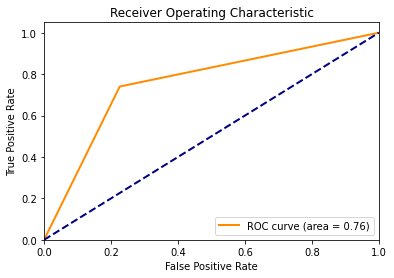

In [97]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc

# Compute ROC curve and ROC area
fpr, tpr, _ = roc_curve(y_test, y_pred)
roc_auc = auc(fpr, tpr)

# Plot
plt.figure()
lw = 2
plt.plot(fpr, tpr, color='darkorange', lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

# Feature analysis

In [98]:
# feature importance
import numpy as np
print(f"Feature importance of ranker:")
importances = model_new.feature_importances_
indices = np.argsort(importances)[::-1]
feature_order = []
for f in range(_train_df.shape[1]):
    if f < len(indices):
        print(
            "%2d) %-*s %f" % (f + 1, 30, feature_list[indices[f]], importances[indices[f]])
        )
        feature_order.append(feature_list[indices[f]])

Feature importance of ranker:
 1) f_num_views_from_LEAF_cat_in_last_30_days 0.119166
 2) f_max_LEAF_cat_view_propensity_cosine_sim_in_last_30_days 0.072913
 3) f_max_num_views_between_purchases_in_LEAF_cat 0.049198
 4) f_max_META_cat_view_propensity_jaccard_sim_in_last_60_days 0.035871
 5) f_max_LEAF_cat_view_propensity_cosine_sim_in_last_14_days 0.032905
 6) f_time_since_last_view_from_LEAF_cat 0.028823
 7) f_mean_num_views_between_purchases_in_LEAF_cat 0.027871
 8) f_num_purchases_from_LVL2_cat_in_last_60_days 0.025503
 9) f_num_views_from_LEAF_cat_in_last_60_days 0.025158
10) f_entropy_for_META_cat_views   0.024766
11) f_num_views_from_LEAF_cat_in_last_14_days 0.023709
12) f_time_since_last_view_from_LVL2_cat 0.022702
13) f_max_LEAF_cat_view_propensity_jaccard_sim_in_last_30_days 0.021816
14) f_num_views_from_LEAF_cat_in_last_5_days 0.021454
15) f_max_LEAF_cat_view_propensity_jaccard_sim_in_last_60_days 0.020064
16) f_time_from_last_view_to_last_purchase_in_LEAF_cat 0.017503
17) f_m

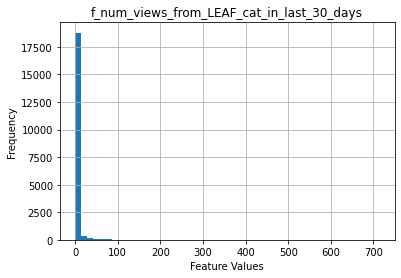

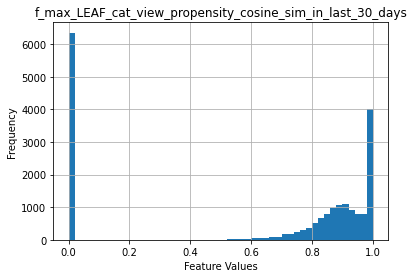

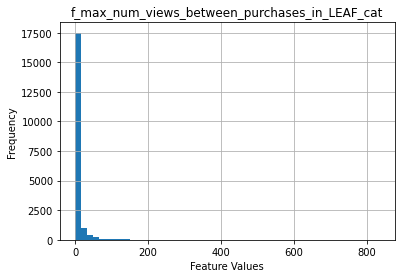

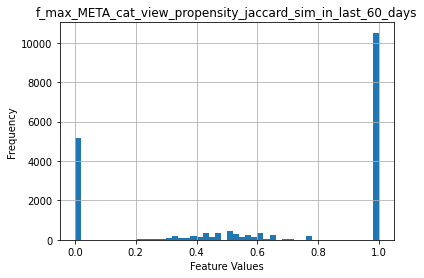

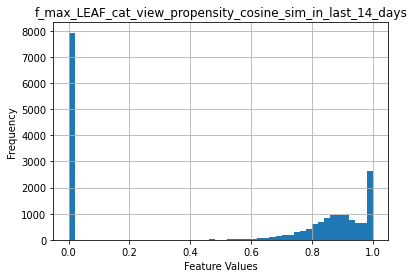

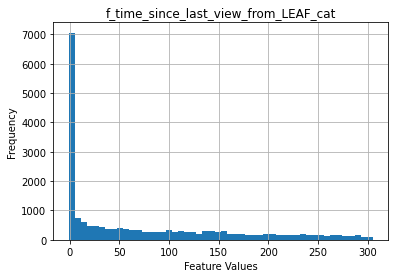

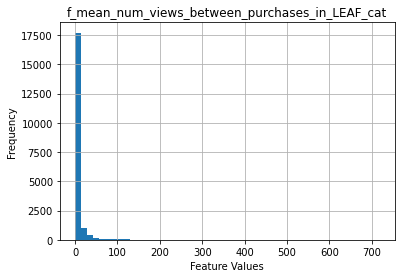

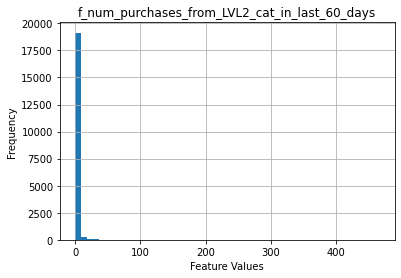

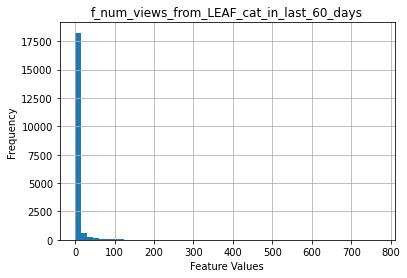

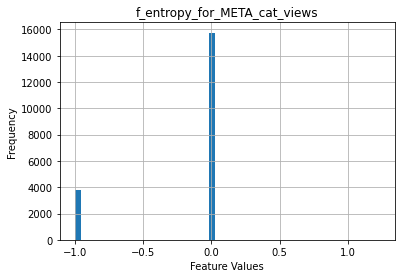

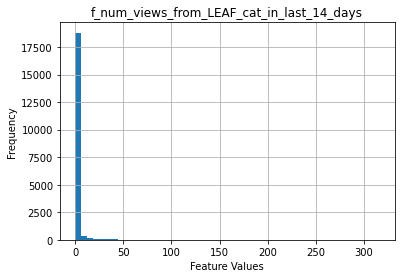

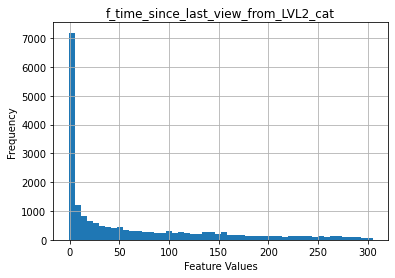

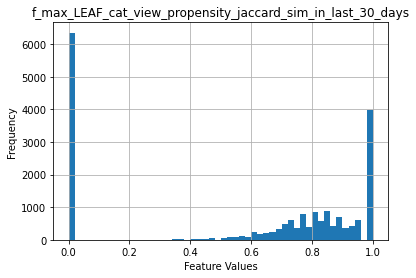

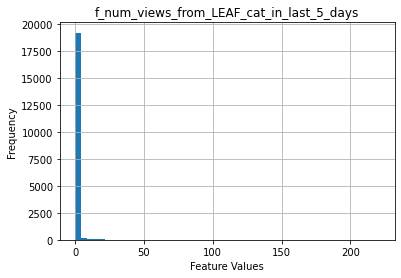

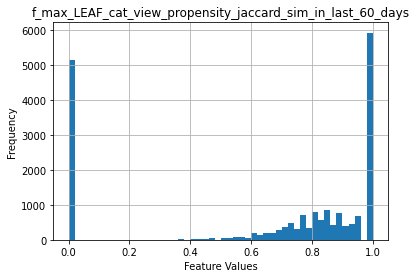

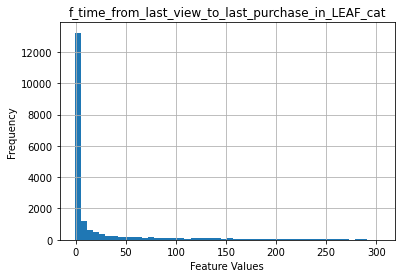

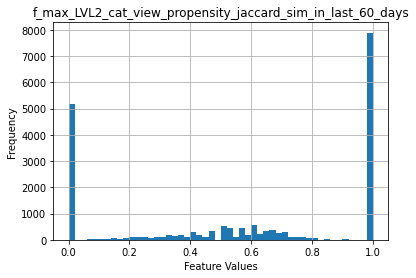

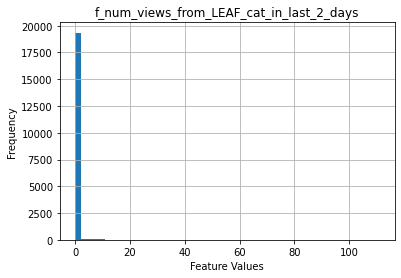

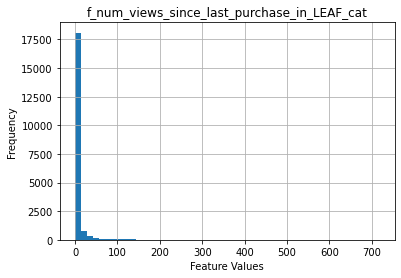

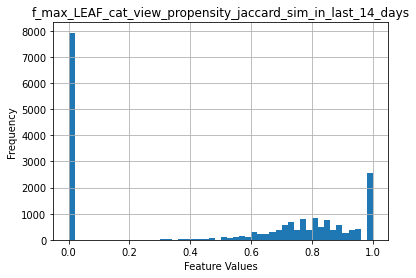

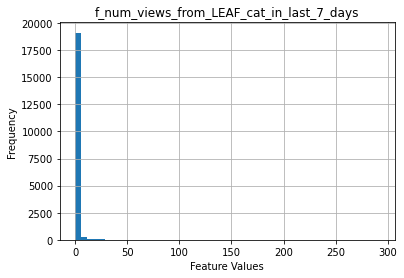

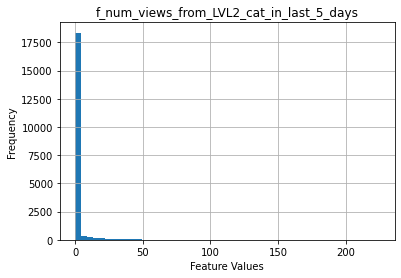

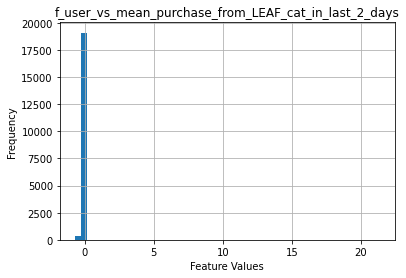

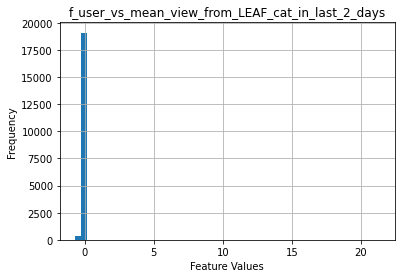

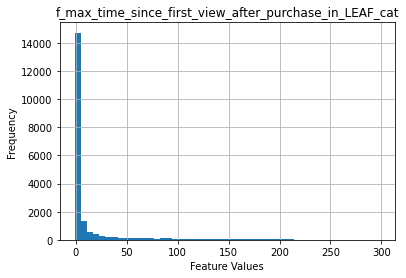

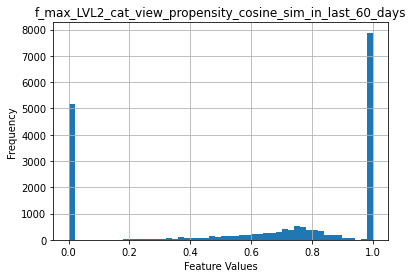

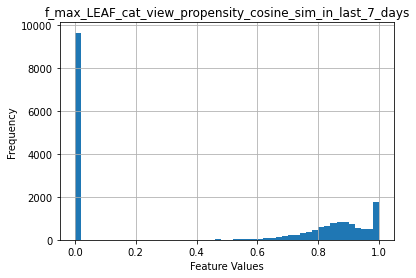

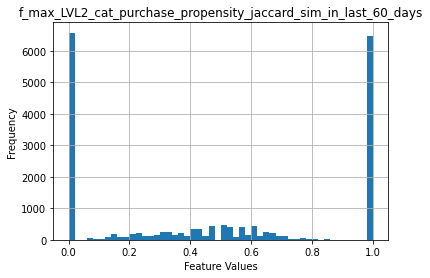

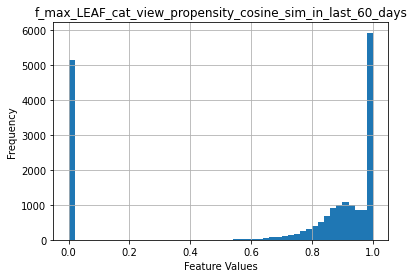

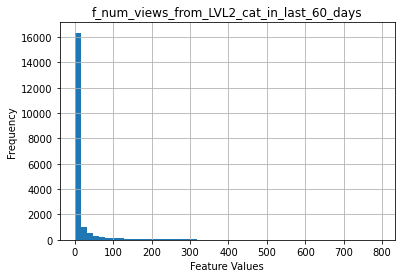

In [99]:
# feature distributions
import matplotlib.pyplot as plt

top_30_features = feature_order[0:30]
for i, feature_name in enumerate(top_30_features):
    eval_df[feature_name].hist(bins=50)
    plt.title(feature_name)
    plt.xlabel('Feature Values')
    plt.ylabel('Frequency')
    plt.show()

In [27]:
#!pip install shap --user --proxy=httpproxy-tcop.vip.ebay.com:80 

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 545.7/545.7 kB 14.4 MB/s eta 0:00:00a 0:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.5/3.5 MB 116.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 34.6/34.6 MB 24.6 MB/s eta 0:00:00a 0:00:01

[notice] A new release of pip is available: 23.0 -> 24.0
[notice] To update, run: pip install --upgrade pip


In [ ]:
import shap 
import matplotlib.pyplot as plt
# Create the explainer
explainer = shap.TreeExplainer(model)

# Compute SHAP values
shap_values = explainer.shap_values(_train_df[feature_list])

# Set the figure size
plt.figure(figsize=(20, 10))

shap.summary_plot(shap_values, _train_df[feature_list], plot_size=[30,20])

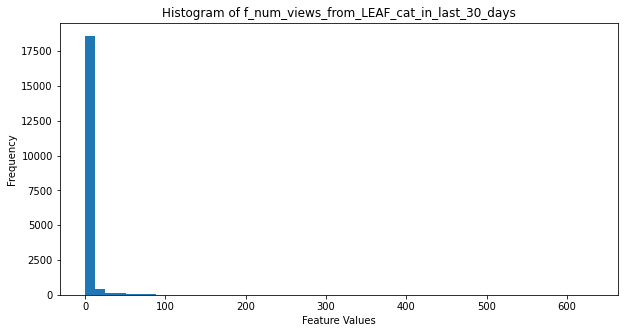

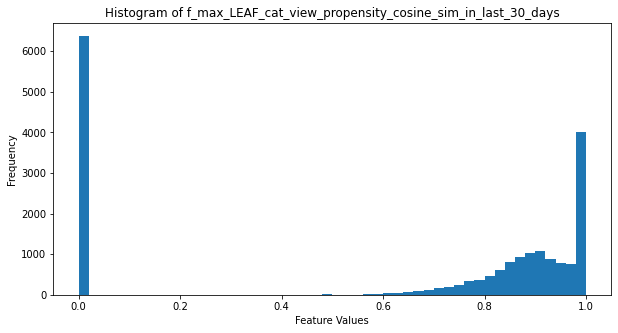

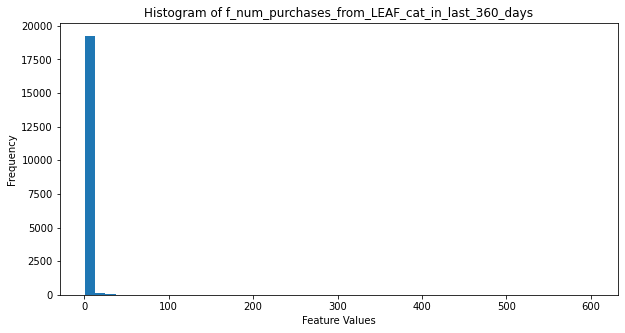

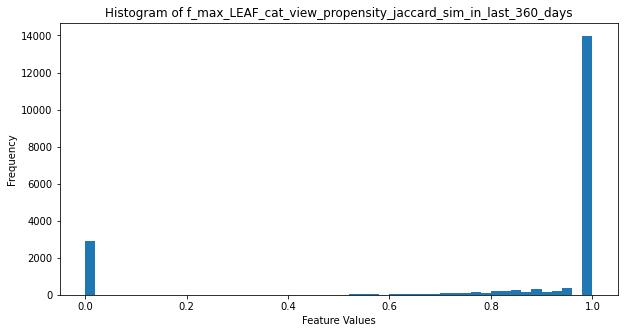

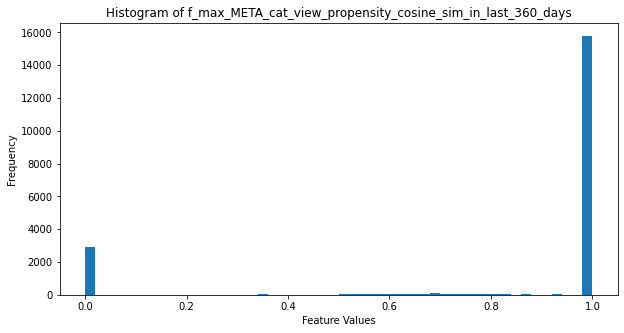

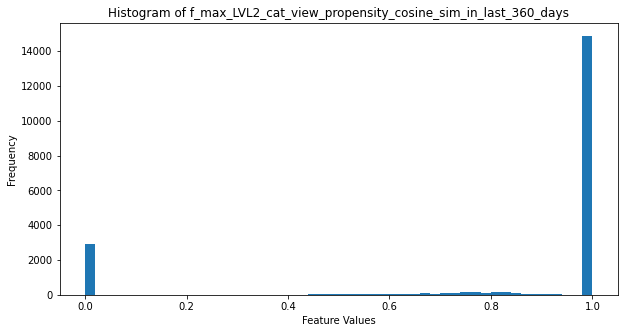

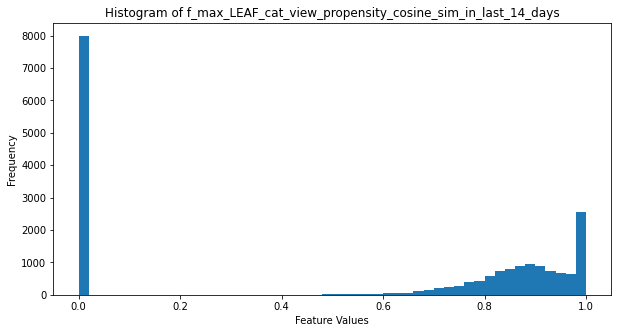

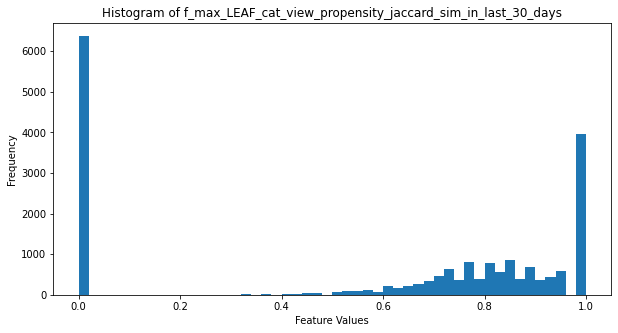

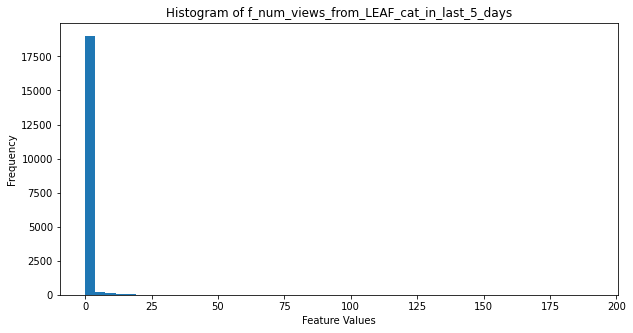

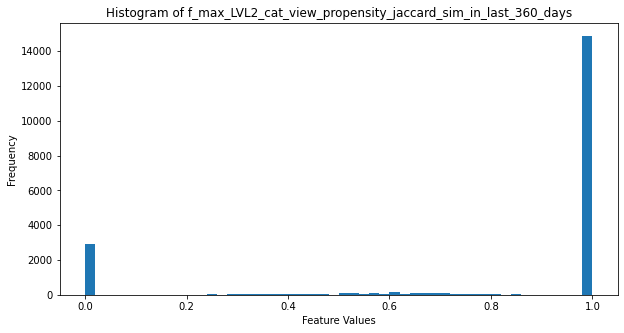

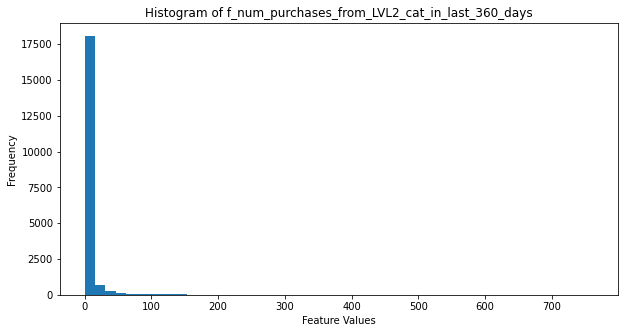

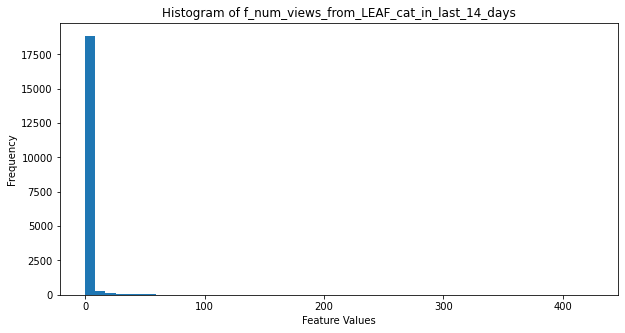

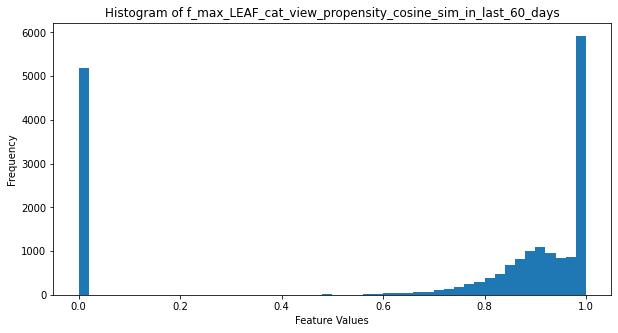

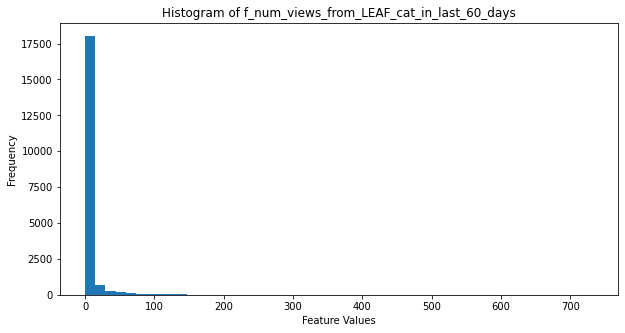

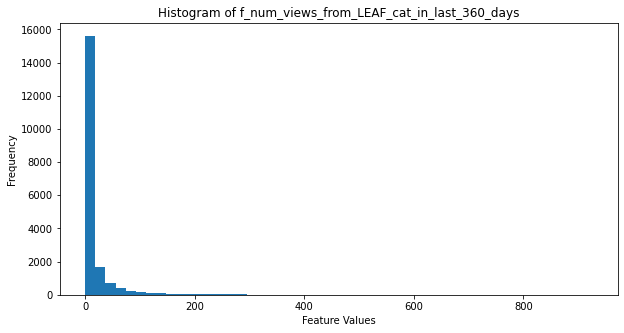

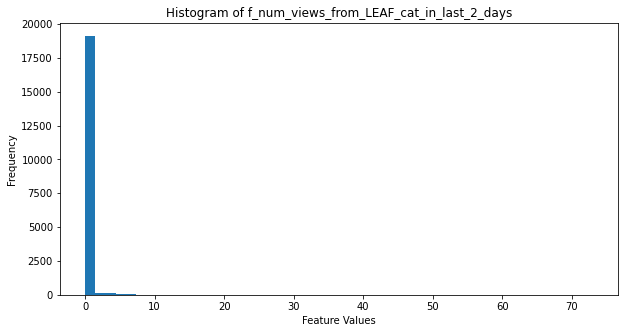

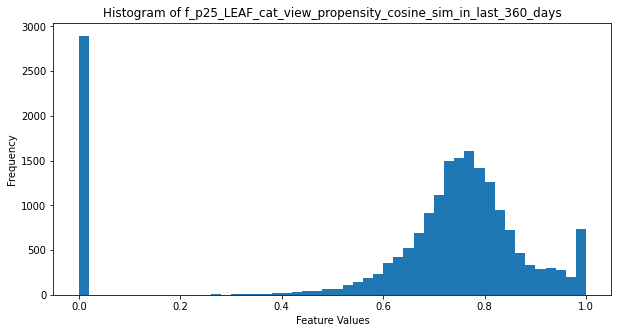

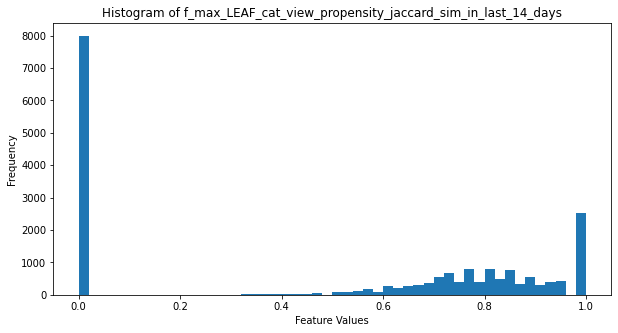

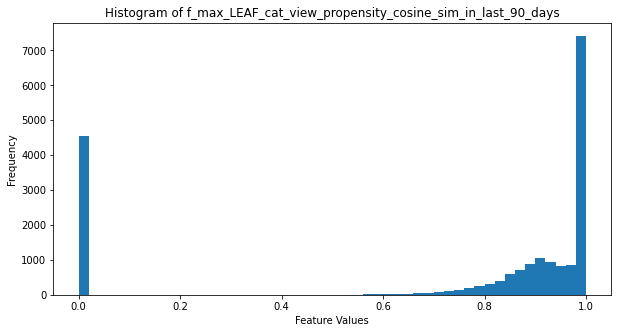

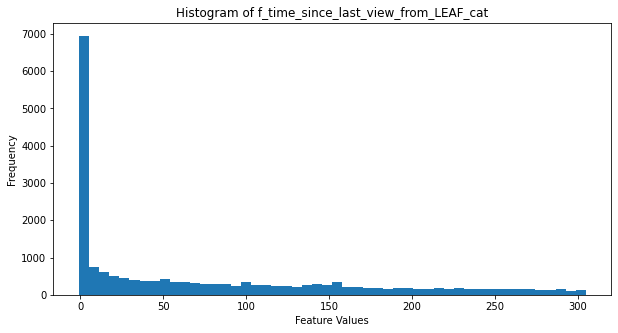

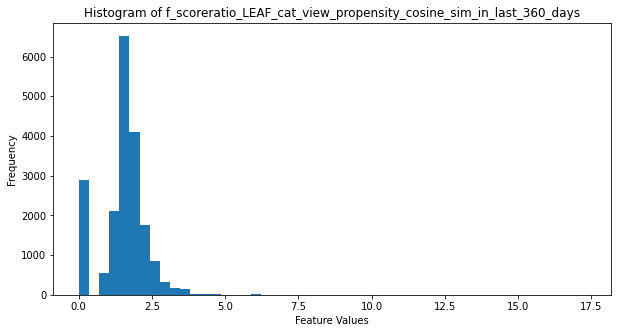

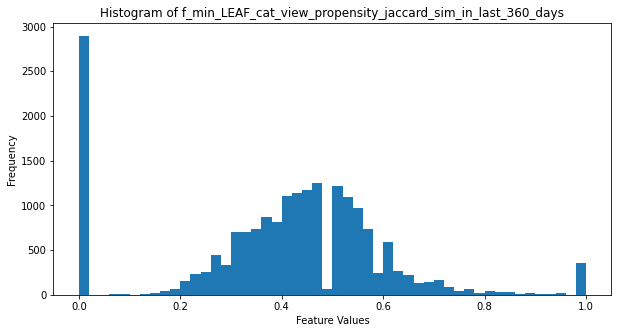

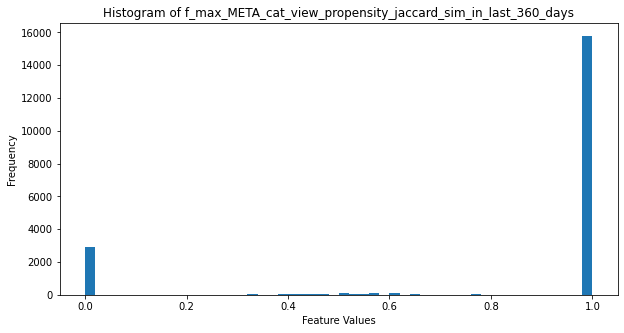

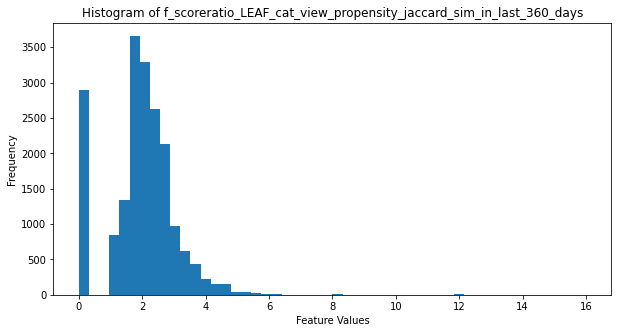

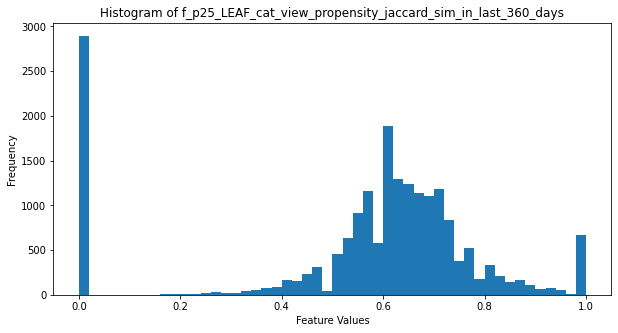

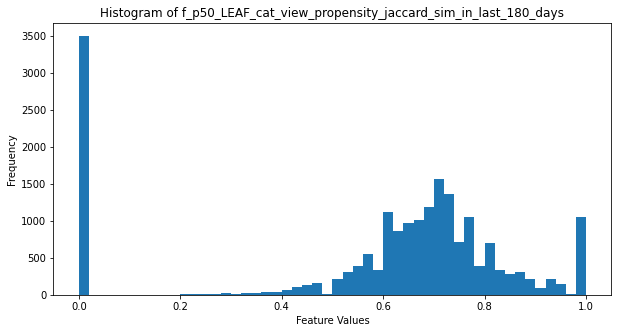

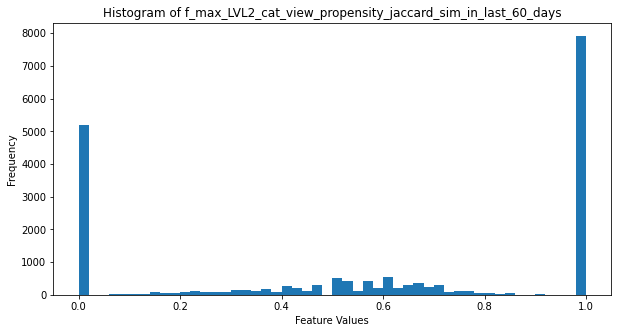

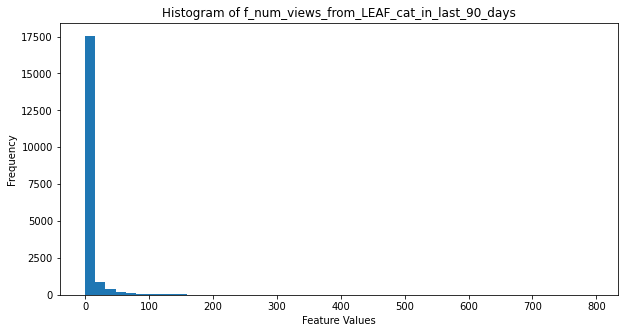

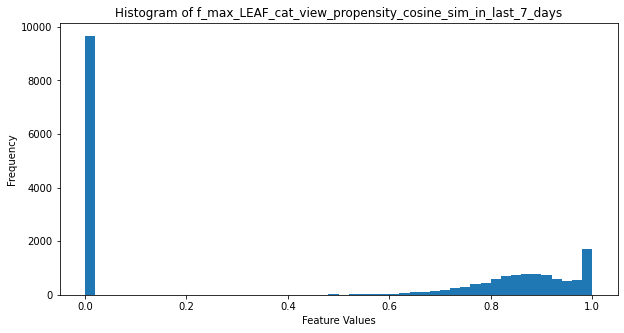

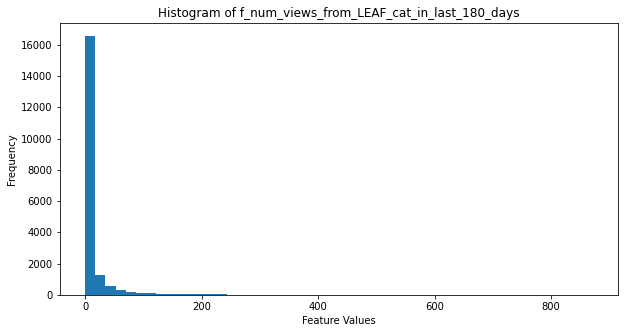

,Feature Name,Percent -1,Percent 0,Percent > 0,Percent NA,Average Value (excluding -1 and 0)
0,f_num_views_from_LEAF_cat_in_last_30_days,0.00000,81.991807,18.008193,0.0,16.156668
1,f_max_LEAF_cat_view_propensity_cosine_sim_in_l...,0.00000,32.657450,67.342550,0.0,0.904415
2,f_num_purchases_from_LEAF_cat_in_last_360_days,0.00000,0.000000,100.000000,0.0,2.256887
3,f_max_LEAF_cat_view_propensity_jaccard_sim_in_...,0.00000,14.818228,85.181772,0.0,0.972180
4,f_max_META_cat_view_propensity_cosine_sim_in_l...,0.00000,14.818228,85.181772,0.0,0.983482
5,f_max_LVL2_cat_view_propensity_cosine_sim_in_l...,0.00000,14.838710,85.161290,0.0,0.970155
6,f_max_LEAF_cat_view_propensity_cosine_sim_in_l...,0.00000,40.921659,59.078341,0.0,0.884045
7,f_max_LEAF_cat_view_propensity_jaccard_sim_in_...,0.00000,32.657450,67.342550,0.0,0.848067
8,f_num_views_from_LEAF_cat_in_last_5_days,0.00000,94.280594,5.719406,0.0,8.166517
9,f_max_LVL2_cat_view_propensity_jaccard_sim_in_...,0.00000,14.838710,85.161290,0.0,0.953930


In [18]:
import pandas as pd
import matplotlib.pyplot as plt

top_30_features = feature_order[0:30]  # Select the top 30 features

# Initialize a list to store the results
results = []

for feature_name in top_30_features:
    # Calculate counts
    total_count = eval_df[feature_name].count()  # Counts non-NaN values
    count_na = eval_df[feature_name].isna().sum()  # Count NaN values
    count_minus_one = (eval_df[feature_name] == -1).sum()
    count_zero = (eval_df[feature_name] == 0).sum()
    count_above_zero = (eval_df[feature_name] > 0).sum()
    
    # Calculate percentages
    percent_minus_one = (count_minus_one / total_count) * 100 if total_count > 0 else 0
    percent_zero = (count_zero / total_count) * 100 if total_count > 0 else 0
    percent_above_zero = (count_above_zero / total_count) * 100 if total_count > 0 else 0
    percent_na = (count_na / (total_count + count_na)) * 100 if (total_count + count_na) > 0 else 0  # Percentage of NaNs
    
    # Calculate average value excluding NaNs, -1, and 0
    average_value = eval_df[eval_df[feature_name] > 0][feature_name].mean()
    
    # Append the results to the list
    results.append({
        'Feature Name': feature_name,
        'Percent -1': percent_minus_one,
        'Percent 0': percent_zero,
        'Percent > 0': percent_above_zero,
        'Percent NA': percent_na,
        'Average Value (excluding -1 and 0)': average_value
    })
    
    # Plot histogram
    plt.figure(figsize=(10, 5))
    eval_df[feature_name].hist(bins=50)
    plt.title(f'Histogram of {feature_name}')
    plt.xlabel('Feature Values')
    plt.ylabel('Frequency')
    plt.grid(False)  # Optionally disable the grid
    plt.show()  # Display the plot

# Create a DataFrame from the results list
results_df = pd.DataFrame(results)

# Print the results
print(results_df)


In [105]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.special import kl_div

# Function to calculate Jensen-Shannon Divergence
def jensen_shannon_divergence(p, q):
    """Calculate the Jensen-Shannon divergence between two distributions."""
    p = p / np.sum(p)  # Normalize
    q = q / np.sum(q)  # Normalize
    m = 0.5 * (p + q)  # Average distribution
    return 0.5 * (kl_div(p, m).sum() + kl_div(q, m).sum())

# Function to calculate Overlap Coefficient
def overlap_coefficient(p, q):
    """Calculate the overlap coefficient between two distributions."""
    return np.sum(np.minimum(p, q))

# Initialize a list to store the results
results = []

# Loop through the top 30 features
for feature_name in top_30_features:
    # Calculate histograms for label 0 and label 1
    hist_0, bin_edges_0 = np.histogram(eval_df[eval_df['label'] == 0][feature_name], bins=50, density=True)
    hist_1, bin_edges_1 = np.histogram(eval_df[eval_df['label'] == 1][feature_name], bins=50, density=True)

    # Calculate JSD and Overlap
    jsd = jensen_shannon_divergence(hist_0, hist_1)
    overlap = overlap_coefficient(hist_0, hist_1)

    # Append the results to the list
    results.append({
        'Feature Name': feature_name,
        'Jensen-Shannon Divergence': jsd,
        'Overlap Coefficient': overlap
    })

# Create a DataFrame from the results list
results_df = pd.DataFrame(results)

# Print the results
results_df


,Feature Name,Jensen-Shannon Divergence,Overlap Coefficient
0,f_num_views_from_LEAF_cat_in_last_30_days,0.03,0.07
1,f_max_LEAF_cat_view_propensity_cosine_sim_in_last_30_days,0.06,35.46
2,f_num_purchases_from_LEAF_cat_in_last_360_days,0.04,0.07
3,f_max_LEAF_cat_view_propensity_jaccard_sim_in_last_360_days,0.01,46.26
4,f_max_META_cat_view_propensity_cosine_sim_in_last_360_days,0.01,46.59
5,f_max_LVL2_cat_view_propensity_cosine_sim_in_last_360_days,0.01,46.65
6,f_max_LEAF_cat_view_propensity_cosine_sim_in_last_14_days,0.06,35.88
7,f_max_LEAF_cat_view_propensity_jaccard_sim_in_last_30_days,0.06,35.50
8,f_num_views_from_LEAF_cat_in_last_5_days,0.04,0.26
9,f_max_LVL2_cat_view_propensity_jaccard_sim_in_last_360_days,0.01,46.60


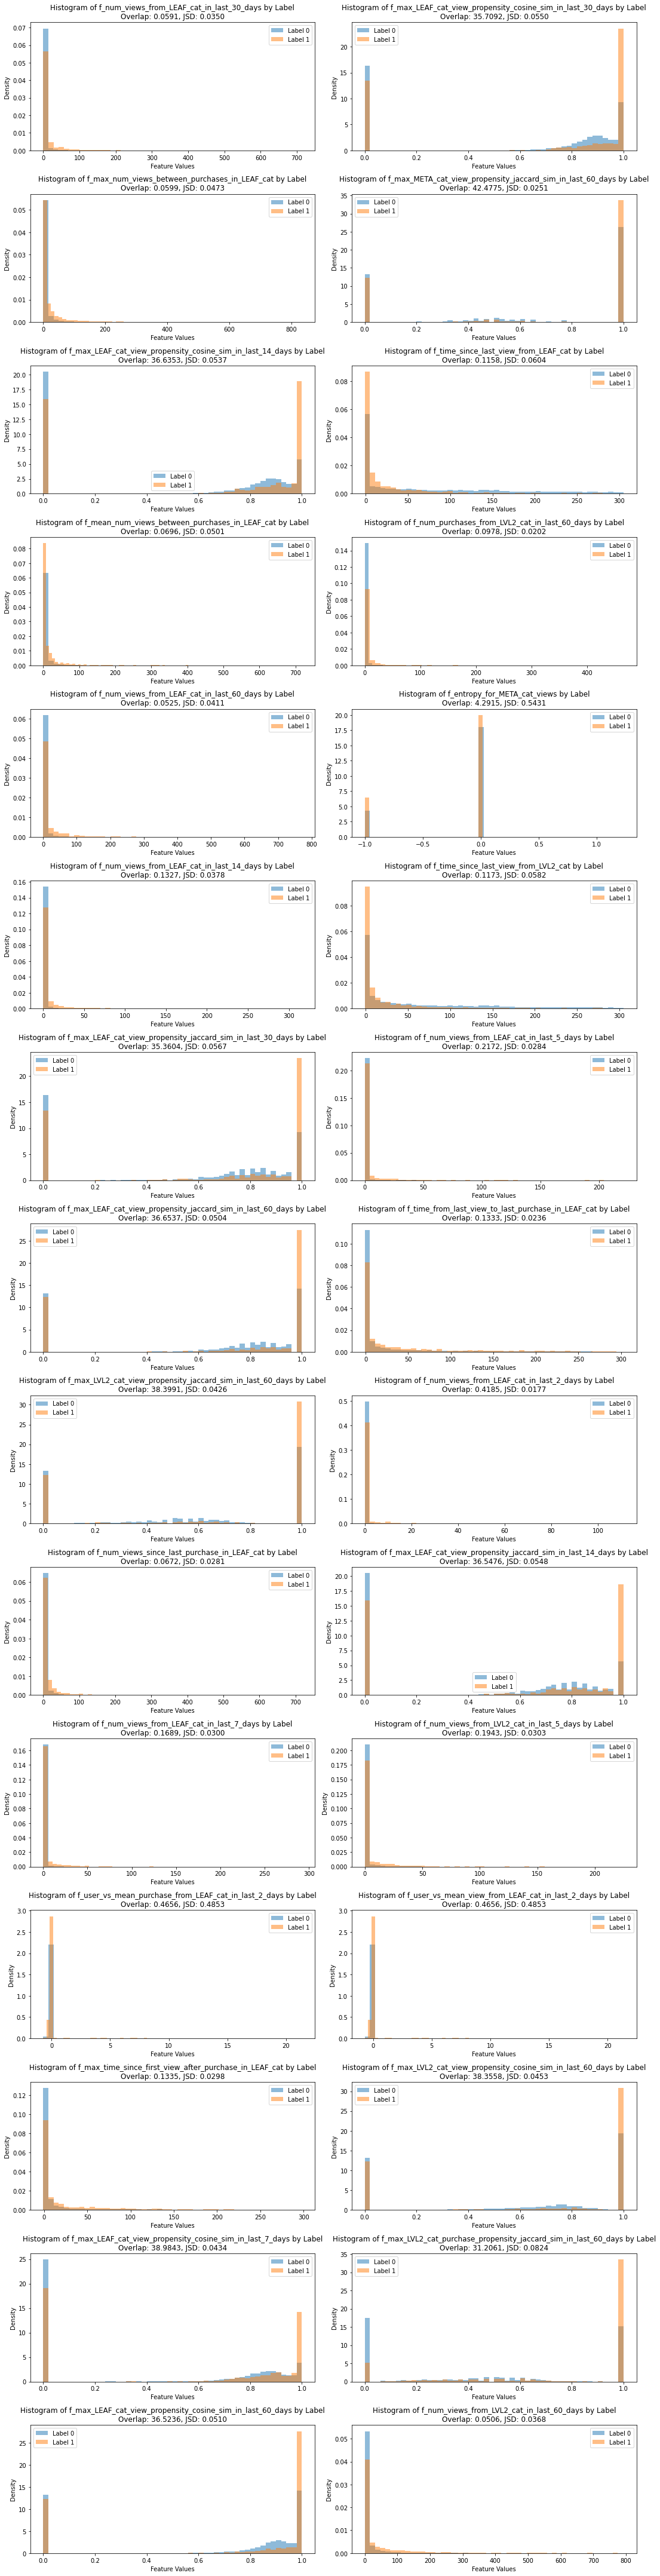

                                         Feature Name  Percent -1  Percent 0  \
0           f_num_views_from_LEAF_cat_in_last_30_days    0.000000  82.051413   
1   f_max_LEAF_cat_view_propensity_cosine_sim_in_l...    0.000000  32.323747   
2       f_max_num_views_between_purchases_in_LEAF_cat    0.000000  47.620260   
3   f_max_META_cat_view_propensity_jaccard_sim_in_...    0.000000  26.256045   
4   f_max_LEAF_cat_view_propensity_cosine_sim_in_l...    0.000000  40.386867   
5                f_time_since_last_view_from_LEAF_cat   29.854925   0.000000   
6      f_mean_num_views_between_purchases_in_LEAF_cat    0.000000  47.620260   
7       f_num_purchases_from_LVL2_cat_in_last_60_days    0.000000  67.248664   
8           f_num_views_from_LEAF_cat_in_last_60_days    0.000000  72.471367   
9                        f_entropy_for_META_cat_views   19.368796  80.183253   
10          f_num_views_from_LEAF_cat_in_last_14_days    0.000000  88.694324   
11               f_time_since_last_view_

In [100]:
import pandas as pd
import matplotlib.pyplot as plt
from scipy.special import kl_div
import numpy as np

# Function to calculate the overlap coefficient
def overlap_coefficient(p, q):
    return np.sum(np.minimum(p, q))

# Function to calculate the Jensen-Shannon Divergence
def jensen_shannon_divergence(p, q):
    p = p / np.sum(p)  # Normalize to probabilities
    q = q / np.sum(q)  # Normalize to probabilities
    m = 0.5 * (p + q)  # Average distribution
    return 0.5 * (kl_div(p, m).sum() + kl_div(q, m).sum())

top_30_features = feature_order[0:30]  # Select the top 30 features

# Initialize a list to store the results
results = []

# Set the number of columns for the plots
n_cols = 2
n_rows = (len(top_30_features) + n_cols - 1) // n_cols  # Calculate the number of rows needed

# Create a figure and axes for subplots
fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, n_rows * 4))
axes = axes.flatten()  # Flatten the 2D array of axes to 1D

for idx, feature_name in enumerate(top_30_features):
    # Calculate counts
    total_count = eval_df[feature_name].count()  # Counts non-NaN values
    count_na = eval_df[feature_name].isna().sum()  # Count NaN values
    count_minus_one = (eval_df[feature_name] == -1).sum()
    count_zero = (eval_df[feature_name] == 0).sum()
    count_above_zero = (eval_df[feature_name] > 0).sum()
    
    # Calculate percentages
    percent_minus_one = (count_minus_one / total_count) * 100 if total_count > 0 else 0
    percent_zero = (count_zero / total_count) * 100 if total_count > 0 else 0
    percent_above_zero = (count_above_zero / total_count) * 100 if total_count > 0 else 0
    percent_na = (count_na / (total_count + count_na)) * 100 if (total_count + count_na) > 0 else 0  # Percentage of NaNs
    
    # Calculate average value excluding NaNs, -1, and 0
    average_value = eval_df[eval_df[feature_name] > 0][feature_name].mean()
    
    # Append the results to the list
    results.append({
        'Feature Name': feature_name,
        'Percent -1': percent_minus_one,
        'Percent 0': percent_zero,
        'Percent > 0': percent_above_zero,
        'Percent NA': percent_na,
        'Average Value (excluding -1 and 0)': average_value
    })

    # Plot histogram per label on the corresponding subplot
    hist_data = {}
    for label in [0, 1]:  # Loop through each label
        subset = eval_df[eval_df['label'] == label]  # Replace 'label' with your actual label column name
        hist_data[label], bin_edges = np.histogram(subset[feature_name], bins=50, density=True)
        axes[idx].hist(subset[feature_name], bins=bin_edges, alpha=0.5, label=f'Label {label}', density=True)

    # Calculate overlap and divergence
    overlap = overlap_coefficient(hist_data[0], hist_data[1])
    divergence = jensen_shannon_divergence(hist_data[0], hist_data[1])
    
    axes[idx].set_title(f'Histogram of {feature_name} by Label\nOverlap: {overlap:.4f}, JSD: {divergence:.4f}')
    axes[idx].set_xlabel('Feature Values')
    axes[idx].set_ylabel('Density')
    axes[idx].legend()
    axes[idx].grid(False)  # Optionally disable the grid

# Adjust layout to prevent overlap
plt.tight_layout()
plt.show()

# Create a DataFrame from the results list
results_df = pd.DataFrame(results)

# Print the results
print(results_df)


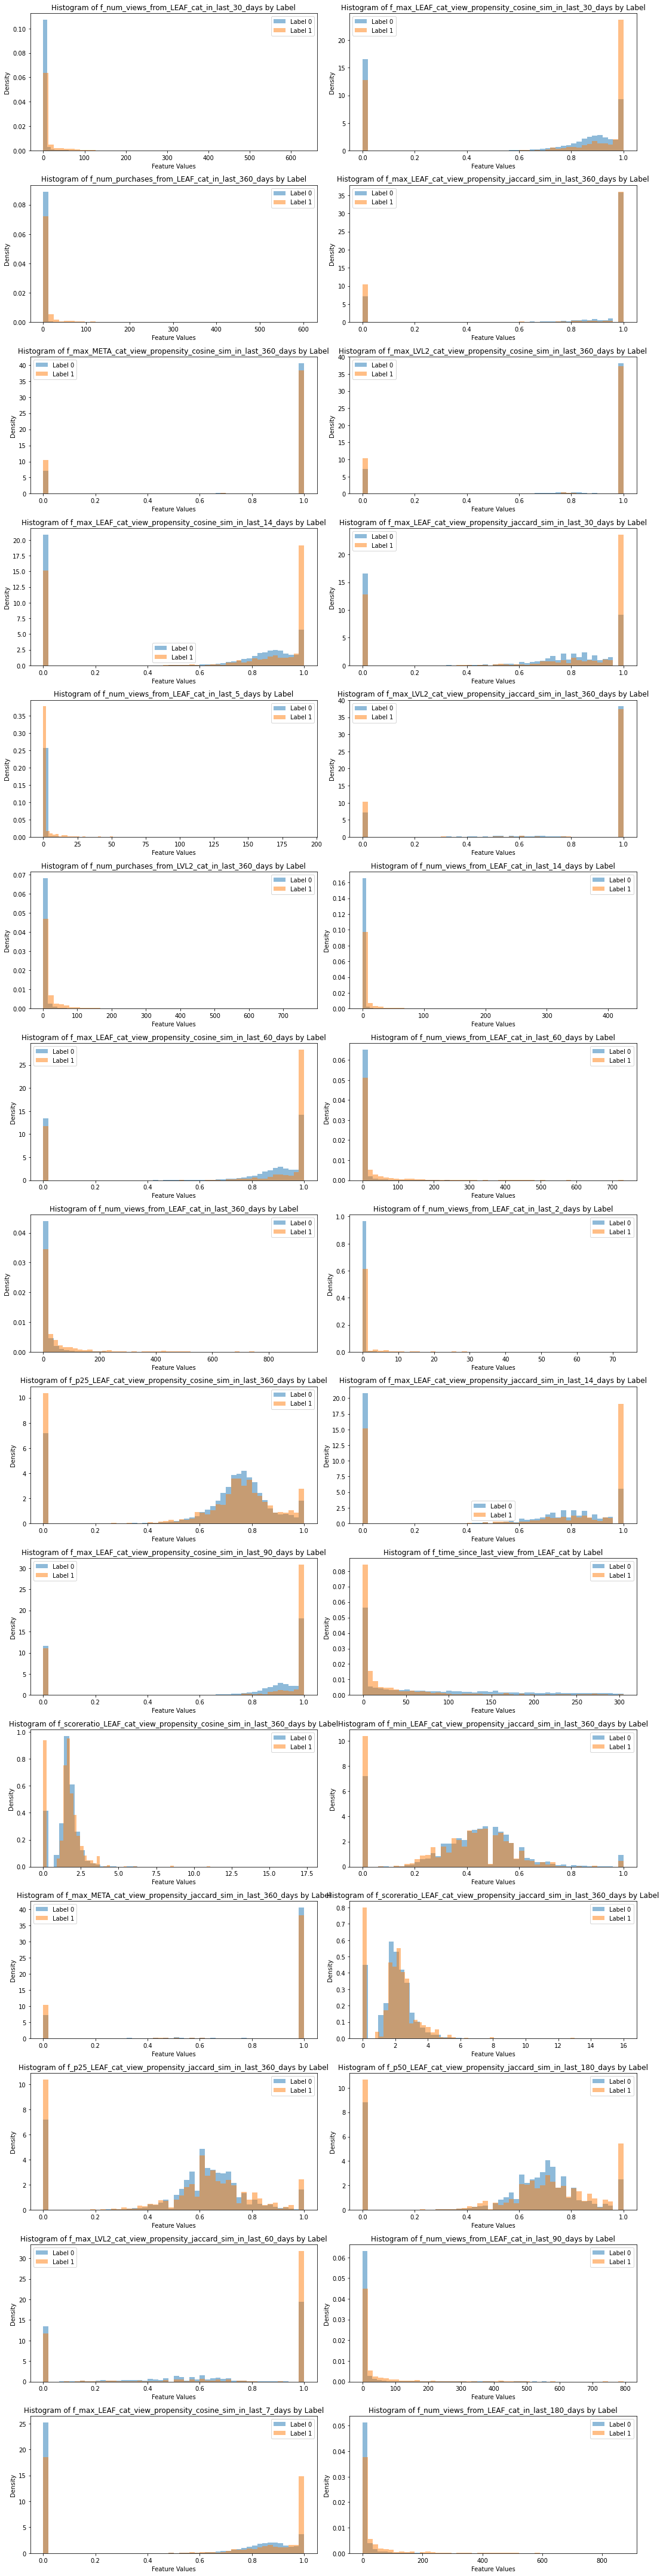

                                                          Feature Name  Percent -1  Percent 0  Percent > 0  Percent NA  Average Value (excluding -1 and 0)
0                            f_num_views_from_LEAF_cat_in_last_30_days        0.00      81.99        18.01        0.00                               16.16
1            f_max_LEAF_cat_view_propensity_cosine_sim_in_last_30_days        0.00      32.66        67.34        0.00                                0.90
2                       f_num_purchases_from_LEAF_cat_in_last_360_days        0.00       0.00       100.00        0.00                                2.26
3          f_max_LEAF_cat_view_propensity_jaccard_sim_in_last_360_days        0.00      14.82        85.18        0.00                                0.97
4           f_max_META_cat_view_propensity_cosine_sim_in_last_360_days        0.00      14.82        85.18        0.00                                0.98
5           f_max_LVL2_cat_view_propensity_cosine_sim_in_last_360_days

In [108]:
import pandas as pd
import matplotlib.pyplot as plt

top_30_features = feature_order[0:30]  # Select the top 30 features

# Initialize a list to store the results
results = []

# Set the number of columns for the plots
n_cols = 2
n_rows = (len(top_30_features) + n_cols - 1) // n_cols  # Calculate the number of rows needed

# Create a figure and axes for subplots
fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, n_rows * 4))
axes = axes.flatten()  # Flatten the 2D array of axes to 1D

for idx, feature_name in enumerate(top_30_features):
    # Calculate counts
    total_count = eval_df[feature_name].count()  # Counts non-NaN values
    count_na = eval_df[feature_name].isna().sum()  # Count NaN values
    count_minus_one = (eval_df[feature_name] == -1).sum()
    count_zero = (eval_df[feature_name] == 0).sum()
    count_above_zero = (eval_df[feature_name] > 0).sum()
    
    # Calculate percentages
    percent_minus_one = (count_minus_one / total_count) * 100 if total_count > 0 else 0
    percent_zero = (count_zero / total_count) * 100 if total_count > 0 else 0
    percent_above_zero = (count_above_zero / total_count) * 100 if total_count > 0 else 0
    percent_na = (count_na / (total_count + count_na)) * 100 if (total_count + count_na) > 0 else 0  # Percentage of NaNs
    
    # Calculate average value excluding NaNs, -1, and 0
    average_value = eval_df[eval_df[feature_name] > 0][feature_name].mean()
    
    # Append the results to the list
    results.append({
        'Feature Name': feature_name,
        'Percent -1': percent_minus_one,
        'Percent 0': percent_zero,
        'Percent > 0': percent_above_zero,
        'Percent NA': percent_na,
        'Average Value (excluding -1 and 0)': average_value
    })
    
    # Plot histogram per label on the corresponding subplot
    for label in [0, 1]:  # Loop through each label
        subset = eval_df[eval_df['label'] == label]  # Replace 'label' with your actual label column name
        axes[idx].hist(subset[feature_name], bins=50, alpha=0.5, label=f'Label {label}', density=True)

    axes[idx].set_title(f'Histogram of {feature_name} by Label')
    axes[idx].set_xlabel('Feature Values')
    axes[idx].set_ylabel('Density')
    axes[idx].legend()
    axes[idx].grid(False)  # Optionally disable the grid

# Adjust layout to prevent overlap
plt.tight_layout()
plt.show()

# Create a DataFrame from the results list
results_df = pd.DataFrame(results)

# Print the results
print(results_df) 


#### Eval data new model:

In [101]:
import pandas as pd
from IPython.display import display, HTML

top_30_features = feature_order[0:30]  # Select the top 30 features

# Initialize a list to store the results
results = []

for feature_name in top_30_features:
    # Calculate counts
    total_count = eval_df[feature_name].count()  # Counts non-NaN values
    count_minus_one = (eval_df[feature_name] == -1).sum()
    count_zero = (eval_df[feature_name] == 0).sum()
    count_above_zero = (eval_df[feature_name] > 0).sum()
    
    # Calculate percentages
    percent_minus_one = (count_minus_one / total_count) * 100 if total_count > 0 else 0
    percent_zero = (count_zero / total_count) * 100 if total_count > 0 else 0
    percent_above_zero = (count_above_zero / total_count) * 100 if total_count > 0 else 0
    
    # Calculate average value excluding NaNs, -1, and 0
    average_value = eval_df[eval_df[feature_name] > 0][feature_name].mean()
    
    # Append the results to the list
    results.append({
        'Feature Name': feature_name,
        'Percent -1': percent_minus_one,
        'Percent 0': percent_zero,
        'Percent > 0': percent_above_zero,
        'Average Value (excluding -1 and 0)': average_value
    })

# Create a DataFrame from the results list
results_df = pd.DataFrame(results)

# Display the results with smaller font size for the "Feature Name" column
results_html = results_df.to_html(escape=False, index=False)
results_html = results_html.replace('<th>', '<th style="font-size: 10px;">')  # Adjust font size as needed
display(HTML(results_html))


Feature Name,Percent -1,Percent 0,Percent > 0,Average Value (excluding -1 and 0)
f_num_views_from_LEAF_cat_in_last_30_days,0.000000,82.051413,17.948587,17.194271
f_max_LEAF_cat_view_propensity_cosine_sim_in_last_30_days,0.000000,32.323747,67.676253,0.904276
f_max_num_views_between_purchases_in_LEAF_cat,0.000000,47.620260,52.379740,16.175607
f_max_META_cat_view_propensity_jaccard_sim_in_last_60_days,0.000000,26.256045,73.743955,0.862417
f_max_LEAF_cat_view_propensity_cosine_sim_in_last_14_days,0.000000,40.386867,59.613133,0.883726
f_time_since_last_view_from_LEAF_cat,29.854925,0.000000,70.145075,107.921698
f_mean_num_views_between_purchases_in_LEAF_cat,0.000000,47.620260,52.379740,11.900819
f_num_purchases_from_LVL2_cat_in_last_60_days,0.000000,67.248664,32.751336,4.504352
f_num_views_from_LEAF_cat_in_last_60_days,0.000000,72.471367,27.528633,20.691198
f_entropy_for_META_cat_views,19.368796,80.183253,0.447951,0.683255


#### new model:

In [103]:
import pandas as pd

# First, filter the DataFrame for label == 1 (True class)
filtered_df = eval_df[eval_df['label'] == 1]

# Split into two groups based on preds
group_0 = filtered_df[filtered_df['preds_new'] == 0]  # False Negatives
group_1 = filtered_df[filtered_df['preds_new'] == 1]  # True Positives

# Initialize a list to store the results
results = []

# Get the top 30 features from feature_order
top_30_features = feature_order[0:30]

# Calculate statistics for each of the top 30 features
for feature in top_30_features:
    # Calculate means for each group, excluding -1 and 0 values
    mean_0 = group_0[group_0[feature] > -1][feature].mean() if not group_0.empty else None
    mean_1 = group_1[group_1[feature] > -1][feature].mean() if not group_1.empty else None
    
    # Append results to the list
    results.append({
        'Feature Name': feature,
        'Mean (preds = 0)': mean_0,  # For False Negatives
        'Mean (preds = 1)': mean_1,  # For True Positives
        'Difference': (mean_1 - mean_0) if mean_0 is not None and mean_1 is not None else None
    })

# Convert results to DataFrame for better visualization
results_df = pd.DataFrame(results)

# Print the title and the results
print("Feature differences where Label == 1 and preds is 0 or 1")
results_df


Feature differences where Label == 1 and preds is 0 or 1


,Feature Name,Mean (preds = 0),Mean (preds = 1),Difference
0,f_num_views_from_LEAF_cat_in_last_30_days,0.373333,19.691617,19.318283
1,f_max_LEAF_cat_view_propensity_cosine_sim_in_l...,0.713107,0.689146,-0.023961
2,f_max_num_views_between_purchases_in_LEAF_cat,3.320000,29.385230,26.065230
3,f_max_META_cat_view_propensity_jaccard_sim_in_...,0.725377,0.712179,-0.013199
4,f_max_LEAF_cat_view_propensity_cosine_sim_in_l...,0.631366,0.638478,0.007112
5,f_time_since_last_view_from_LEAF_cat,121.753425,19.641100,-102.112325
6,f_mean_num_views_between_purchases_in_LEAF_cat,2.132500,17.886591,15.754091
7,f_num_purchases_from_LVL2_cat_in_last_60_days,0.473333,8.582834,8.109501
8,f_num_views_from_LEAF_cat_in_last_60_days,0.933333,31.205589,30.272255
9,f_entropy_for_META_cat_views,0.002513,0.004667,0.002154


In [104]:
import pandas as pd

# Assuming eval_df contains your data and the top 30 features
# Filter the DataFrame for cases where preds == 1 (predicted positive)
filtered_df = eval_df[eval_df['preds_new'] == 1]

# Split into two groups: False Positives (label == 0) and True Positives (label == 1)
group_fp = filtered_df[filtered_df['label'] == 0]  # False Positives
group_tp = filtered_df[filtered_df['label'] == 1]  # True Positives

# Initialize a list to store the results
results = []

# Calculate statistics for each of the top 30 features
top_30_features = feature_order[0:30]  # Assuming feature_order is your list of top 30 features

for feature in top_30_features:
    # Calculate means excluding -1 (if necessary for your case)
    mean_fp = group_fp[group_fp[feature] > -1][feature].mean() if not group_fp.empty else None
    mean_tp = group_tp[group_tp[feature] > -1][feature].mean() if not group_tp.empty else None
    
    # Append results to the list
    results.append({
        'Feature Name': feature,
        'Mean (False Positives, label = 0)': mean_fp,
        'Mean (True Positives, label = 1)': mean_tp,
        'Difference': (mean_tp - mean_fp) if mean_fp is not None and mean_tp is not None else None
    })

# Create a DataFrame from the results
results_df = pd.DataFrame(results)

# Print the title and the results
print("Feature differences where preds == 1 (False Positives vs True Positives)")
results_df


Feature differences where preds == 1 (False Positives vs True Positives)


,Feature Name,"Mean (False Positives, label = 0)","Mean (True Positives, label = 1)",Difference
0,f_num_views_from_LEAF_cat_in_last_30_days,7.060212,19.691617,12.631404
1,f_max_LEAF_cat_view_propensity_cosine_sim_in_l...,0.657374,0.689146,0.031772
2,f_max_num_views_between_purchases_in_LEAF_cat,19.168558,29.385230,10.216672
3,f_max_META_cat_view_propensity_jaccard_sim_in_...,0.695231,0.712179,0.016948
4,f_max_LEAF_cat_view_propensity_cosine_sim_in_l...,0.589499,0.638478,0.048979
5,f_time_since_last_view_from_LEAF_cat,32.640416,19.641100,-12.999317
6,f_mean_num_views_between_purchases_in_LEAF_cat,14.119098,17.886591,3.767493
7,f_num_purchases_from_LVL2_cat_in_last_60_days,2.941984,8.582834,5.640850
8,f_num_views_from_LEAF_cat_in_last_60_days,13.237555,31.205589,17.968034
9,f_entropy_for_META_cat_views,0.004573,0.004667,0.000094


In [16]:
#eval df with pred results 
eval_df.to_parquet('/data/shpx/data/olivyatan/traindf_vi_preds_51024.parquet') 

In [ ]:
if session:
    session.stop()